In [1]:
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler, BatchSampler, SequentialSampler
from torch.utils.data import Dataset, DataLoader
import numpy as np
from bs4 import BeautifulSoup
import re
import pandas as pd
import math
import os
from collections import Counter
from functools import reduce
import glob
from matplotlib import pyplot as plt
from nltk import RegexpTokenizer
from nltk.corpus import stopwords as stopwords_list
import pickle
import sys
import random
from nltk.tag.stanford import CoreNLPPOSTagger
# from nltk.tag.stanford import StanfordTagger as CoreNLPPOSTagger
import bs4

In [2]:
sequence_length = 100


In [3]:
# import pycuda.driver as cuda
# cuda.init()
torch.cuda.is_available()
torch.cuda.current_device()


/usr/local/lib/python3.5/dist-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU0 GeForce GT 750M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


0

In [4]:
class ArticleTextData():
    authors = {}
    texts = {}
    tokenizer = RegexpTokenizer(r'\w+')
    stop = stopwords_list.words("english")

    def __init__(self, filedir=None, filedir_submitted=None, max_classes=None, min_class_freq=None, vocabulary_file=None, 
                 vocabulary=None, authors=None, texts = None, keys_mapping_file=None,
                 stopwords_index=None, stopwords_dim=None,
                references=None, texts_submitted=None,
                classes=None, nr_labels=None, references_index=None, 
                 tail_authors=False, middle_authors=False,
                references_dim=None, class_weights=None, just_abstract=False, 
                 just_contexts=False):
        self.max_classes = max_classes
        self.min_class_freq = min_class_freq
        self.just_abstract = just_abstract
        self.just_contexts = just_contexts
        if authors:
            self.vocabulary = vocabulary
            self.vocabulary_size = len(self.vocabulary) + 1
            self.authors = authors
            self.texts = texts
            self.stopwords_index = stopwords_index
            self.stopwords_dim = stopwords_dim
            self.references = references
            self.references_index = references_index
            self.references_dim = references_dim
            self.classes = classes
            self.nr_labels = nr_labels
            self.class_weights = class_weights
            self.texts_submitted = texts_submitted
        else:
            keys_mapping = None
            if keys_mapping_file:
                keys_mapping = {}
                with open(keys_mapping_file) as f:
                    for line in f:
                        a1, a2 = line.strip().split(",")
                        keys_mapping[a2] = a1
            self._build_dataset(filedir, filedir_submitted, keys_mapping, vocabulary_file=vocabulary_file)
            self.classes, self.nr_labels, self.class_weights = self._build_class_index(
                max_classes=max_classes, min_class_freq=self.min_class_freq,
                tail_authors=tail_authors, middle_authors=middle_authors)
            self._build_references_index()
        self.article_indices = [i for i in self.authors if i in self.texts]

    def __len__(self):
        return len(self.article_indices)
    
    @classmethod
    def _collect_references(cls, filedir, keys_mapping=None):
        filedir = filedir + "/references/"
        filenames = os.listdir(filedir)
        references = {}
        for i, filename in enumerate(filenames):
            article_index = filename.split(".")[0]
            articles = {}

            with open(os.path.join(filedir, filename)) as infile:
                contents = infile.read()
                soup = BeautifulSoup(contents,'xml')
                article_nodes = soup.find_all('biblStruct')
                for article_node in article_nodes:
                    title = article_node.find_all("title")[0].get_text()
                    articles[title] = []
                    authors_nodes = article_node.find_all("author")
                    for author_node in authors_nodes:
                        names = []
                        for name_node in author_node.find_all("forename"):
                            names.append(name_node.get_text().strip())
                        for name_node in author_node.find_all("surname"):
                            names.append(name_node.get_text().strip())
                        if names:
                            articles[title].append(" ".join(names))
            if keys_mapping:
                references[keys_mapping[article_index]] = articles
            else:
                references[article_index] = articles
        return references
            
    @classmethod
    def _normalize_authors(cls, authors):
        normalized_authors = []
        for author in authors:
            author_names = author.split()
            # take inital of first name and full last name
            try:
                normalized_name = " ".join([author_names[0][0], author_names[-1]])
            except:
                sys.stderr.write("Could not normalize name %s\n" % author)
            normalized_authors.append(normalized_name)
        return normalized_authors

    @classmethod
    def _collect_authors(cls, filedir):
        filedir = filedir + "/headers/"
        filenames = os.listdir(filedir)
        for i, filename in enumerate(filenames):
            article_index = filename.split(".")[0]
            cls.authors[article_index] = {}
            with open(os.path.join(filedir, filename)) as infile:
                contents = infile.read()
                soup = BeautifulSoup(contents,'xml')
                title = soup.find_all('title')[0].get_text()
                cls.authors[article_index]['title'] = title
                authors_nodes = soup.find_all('author')
                cls.authors[article_index]['authors'] = []
                for author_node in authors_nodes:
                    names = []
                    for name_node in author_node.find_all('forename'):
                        name = name_node.get_text().strip()
                        # the first (not middle) name is 1-letter long
                        if len(name.split()[0]) == 1 and not names:
                            sys.stderr.write("Suspicious name: %s, article %s\n" % (name, article_index))
                        names.append(name)
                    for name_node in author_node.find_all('surname'):
                        name = name_node.get_text().strip()
                        # exponents
                        if name[-1] in '0123456789':
                            name = name[:-1]
                        names.append(name)
                    if len(names) > 3:
                        sys.stderr.write("Suspicious name: %s\n" % " ".join(names))
                    if names:
                        # TODO: test of name containing non-letter characters
                        cls.authors[article_index]['authors'].append(" ".join(names))

                
    def _collect_texts(self, filedir, keys_mapping=None):
        filenames = glob.glob(filedir + "/contents/*.xml")
        excluded_tags = {'ref'}
        context_window = 50
        ref_contexts = {}
        texts = {}
        for i, filename in enumerate(filenames):
            article_index = filename.split("/")[-1].split(".")[0]
            with open(filename) as infile:
                contents = infile.read()
                soup = BeautifulSoup(contents,'xml')
                body = soup.find_all('text')[0].find_all('body')[0]
                abstract = soup.find_all('abstract')[0]
                title = soup.find_all('title')[0]
                all_texts = []
                ref_contexts_local = []
                for refel in body.find_all('ref'): 
                    if refel.previous and type(refel.previous) is bs4.element.NavigableString: 
                        ref_contexts_local.append(refel.previous[-context_window:]) 
                    if refel.next_sibling and type(refel.next_sibling) is bs4.element.NavigableString:
                        ref_contexts_local.append(refel.next_sibling[:context_window]) 
                    refel.replace_with(" ")
                elements = title.find_all() + abstract.find_all()
                if not self.just_abstract:
                    elements.extend(body.find_all())
                for el in elements:
                    if el.name not in excluded_tags:
                        all_texts.append(el.get_text())
                text = " ".join(filter(None, all_texts))
                # fix syllabified words
                text = re.sub("- ", "", text) # TODO: check
                if keys_mapping:
                    texts[keys_mapping[article_index]] = text
                    ref_contexts[article_index] = " ".join(ref_contexts_local)
                else:
                    texts[article_index] = text
                    ref_contexts[article_index] = " ".join(ref_contexts_local)
        if self.just_contexts:
            return ref_contexts
        else:
            return texts
    
    def random_split(self, proportion1, proportion2=0, max_classes=None,
            min_class_freq=None, tail_authors=False, middle_authors=False):
        
        # Split all text indices
        indices1 = set()
        indices2 = set()
        indices3 = set()
        articles_for_author = {}
        
        for article, article_metadata in self.authors.items():
            author_list = article_metadata['authors']
            for a in author_list:
                if a not in self.classes:
                    continue
                if a not in articles_for_author:
                    articles_for_author[a] = []
                articles_for_author[a].append(article)

        sorted_articles_per_author = sorted(articles_for_author.items(), key=lambda x: len(x[1]), reverse=False)
        for author, articles in sorted_articles_per_author:
            # take first article that is not already in second set, add it to first
            for i in range(len(articles)):
                if articles[i] not in indices2 and articles[i] not in indices3:
                    indices1.add(articles[i])
                    break
            # take first article that is not already in first set, add it to second
            for i in range(len(articles)):
                if articles[i] not in indices1 and articles[i] not in indices3:
                    indices2.add(articles[i])
                    break
            if proportion2: # we want to split it 3-ways
                for i in range(len(articles)):
                    if articles[i] not in indices1 and articles[i] not in indices2:
                        indices3.add(articles[i])
                        break
            
        # what is left
        articles = set(self.texts.keys()).difference(indices2).difference(indices1).difference(indices3)
        n1 = int(proportion1*len(self.texts.keys()))
        if not proportion2:
            p2 = 1-proportion1
        else:
            p2 = proportion2
        n2 = int(proportion2*len(self.texts.keys()))
        n1_remaining = max(n1-len(indices1), 0)
        ia1 = set(random.sample(population=articles, k=min(n1_remaining, len(articles))))
        indices1 = indices1.union(ia1)
        n2_remaining = max(n2-len(indices2), 0)
        articles = articles.difference(indices1)
        ia2 = set(random.sample(population=articles, k=min(n2_remaining, len(articles))))
        indices2 = indices2.union(ia2)
        ia3 = articles.difference(indices1).difference(indices2)
        indices3 = indices3.union(ia3)
        
        # Filter out authors that don't occur in all 3 index sets
        valid_authors = set()
        min_occs = 1000000
        for aut, indices in articles_for_author.items():
            # keep the author if it occurs in both sets
            occs1, occs2, occs3 = len(set(indices).intersection(indices1)), len(set(indices).intersection(indices2)), len(set(indices).intersection(indices3))
            if occs1 and occs2 and (occs3 or not indices3):
                valid_authors.add(aut)
                if occs1+occs2+occs3 < min_occs:
                    min_occs = occs1+occs2+occs3

        authors1 = {i: self.authors[i] for i in indices1}
        authors2 = {i: self.authors[i] for i in indices2}
        authors3 = {i: self.authors[i] for i in indices3}
                    
        # Filter out texts which don't have any of the valid authors
        texts1 = {i: self.texts[i] for i in indices1 
                  if i in self.texts and [a for a in authors1[i]['authors'] if a in valid_authors]} # TODO: why are there indices which are not in self.texts?        
        texts2 = {i: self.texts[i] for i in indices2 
                  if i in self.texts and [a for a in authors2[i]['authors'] if a in valid_authors]}
        texts3 = {i: self.texts[i] for i in indices3 
                  if i in self.texts and [a for a in authors3[i]['authors'] if a in valid_authors]}
        texts_submitted = {i: self.texts_submitted[i] for i in texts3 if i in self.texts_submitted}
        

        print("minimum articles per author", min_occs)

        # Filter out authors which don't occur in any text anymore
        authors_in1 = set()
        authors_in2 = set()
        authors_in3 = set()
        for article, metadata in self.authors.items():
            authors = metadata['authors']
            if article not in texts1 and article not in texts2 and article not in texts3:
                continue
            if article in texts1:
                authors_in1 = authors_in1.union(set([a for a in authors if a in valid_authors]))
            if article in texts2:
                authors_in2 = authors_in2.union(set([a for a in authors if a in valid_authors]))
            if article in texts3:
                authors_in3 = authors_in3.union(set([a for a in authors if a in valid_authors]))
        valid_authors_with_texts = authors_in1.union(authors_in2).union(authors_in3)
        # Rebuild the class index using the authors that are left  
        classes, nr_labels, class_weights = self._build_class_index(
            valid_authors = valid_authors_with_texts, max_classes=max_classes,
            min_class_freq=min_class_freq, tail_authors=tail_authors, middle_authors=middle_authors)
      
        print("valid authors", len(valid_authors), "with texts", len(valid_authors_with_texts))
        data1 = ArticleTextData(authors=authors1, texts=texts1, vocabulary=self.vocabulary, 
                                max_classes=self.max_classes, stopwords_index=self.stopwords_index, 
                                stopwords_dim=self.stopwords_dim, references=self.references,
                               classes=classes, nr_labels=nr_labels, references_index=self.references_index,
                                references_dim=self.references_dim, class_weights=class_weights)
        data2 = ArticleTextData(authors=authors2, texts=texts2, vocabulary=self.vocabulary, 
                                max_classes=self.max_classes, stopwords_index=self.stopwords_index,
                               stopwords_dim=self.stopwords_dim, references=self.references,
                               classes=classes, nr_labels=nr_labels, references_index=self.references_index,
                                references_dim=self.references_dim, class_weights=class_weights)
    
        if proportion2:
            data3 = ArticleTextData(authors=authors3, texts=texts3, vocabulary=self.vocabulary, 
                                max_classes=self.max_classes, stopwords_index=self.stopwords_index,
                               stopwords_dim=self.stopwords_dim, references=self.references,
                               classes=classes, nr_labels=nr_labels, references_index=self.references_index,
                                references_dim=self.references_dim, class_weights=class_weights,
                                   texts_submitted=texts_submitted)
            
            data4 = ArticleTextData(authors=authors3, texts=texts_submitted, vocabulary=self.vocabulary, 
                    max_classes=self.max_classes, stopwords_index=self.stopwords_index,
                   stopwords_dim=self.stopwords_dim, references=self.references_submitted,
                   classes=classes, nr_labels=nr_labels, references_index=self.references_index,
                    references_dim=self.references_dim, class_weights=class_weights,
                       texts_submitted=texts_submitted)
            
            return data1, data2, data3, data4
        
        return data1, data2
    


  
    def _build_vocabulary(self, min_freq=50, max_words=50000, vocabulary_file=None):
        self.vocabulary = {}
        self.stopwords_index = {self.stop[i]: i for i in range(len(self.stop))}
        self.stopwords_dim = len(self.stopwords_index)
        if vocabulary_file:
            self.vocabulary = pickle.load(open(vocabulary_file, "rb"))
            self.vocabulary_size = len(self.vocabulary)
            return
        word_freqs = Counter() 
        for art, text in self.texts.items():
            tokenized_text = self._tokenize(text, filter_stopwords=True)
            word_freqs.update(tokenized_text)
        i = 1 # starts with 1, keeping 0 for padding
        for word, freq in word_freqs.most_common():
            if (min_freq and word_freqs[word] < min_freq) or i > max_words:
                print("min freq is", freq)
                break
            if re.match("^[0-9]+$", word):
                continue
            self.vocabulary[word] = i
            i += 1
        self.vocabulary_size = len(self.vocabulary) + 1 # to include unknowns
 

    @classmethod
    def _tokenize(cls, text, filter_stopwords=False, keep_only_stopwords=False):
        tokenized_text = cls.tokenizer.tokenize(text.lower())
        if filter_stopwords:
            filtered_text = list(filter(lambda w: w not in cls.stop, tokenized_text))
        else:
            filtered_text = tokenized_text
        if keep_only_stopwords:
            filtered_text = list(filter(lambda w: w in cls.stop, tokenized_text))
        else:
            filtered_text = list(filter(lambda w: len(w)>1, filtered_text))
        return filtered_text

    def _stopwords(cls, tokenized_text):
        return [w for w in tokenized_text if w in cls.stop]
    
    def _build_references_index(self):
        self.references_index = {}
        cnt = 0
        for article, references in self.references.items():
            if article not in self.authors:
                continue
            article_authors = self.authors[article]['authors']
            # only consider references in our dataset (covered by our limited classes)
            labels = [self.classes.get(a, -1) for a in article_authors]
            if all([label<0 for label in labels]):
                continue
            for title, authors in references.items():
                authors = self._normalize_authors(authors)
                for author in authors:
                    if author not in self.references_index:
                        self.references_index[author] = cnt
                        cnt += 1
        self.references_dim = len(self.references_index)
    
    @classmethod
    def _build_class_index(cls, max_classes=None, min_class_freq=None, valid_authors=None, 
                           top_authors=False, tail_authors=False, middle_authors=False):
        class_freq = Counter()
        if not tail_authors and not middle_authors and max_classes:
            top_authors=True
        for article, article_metadata in cls.authors.items():
            author_list = article_metadata['authors']
            class_freq.update(author_list)
        if top_authors:
            all_authors = class_freq.most_common(max_classes)
        if tail_authors:
            all_authors = []
            for a, f in sorted(class_freq.items(), key=lambda t:t[1], reverse=False):
                if f >= min_class_freq:
                    all_authors.append((a,f))
                if len(all_authors) > max_classes:
                    break
        middle_authors_i1 = 0
        middle_authors_i2 = len(class_freq)
        if middle_authors:
            all_authors = []
            for a, f in class_freq.most_common():
                if min_class_freq and (f < min_class_freq):
                    continue
                if valid_authors and a not in valid_authors:
                    continue
                all_authors.append((a,f))
            total_authors = len(all_authors)
            print("total authors", total_authors)
            middle_authors_i1 = max((total_authors - max_classes)/2, 0)
            middle_authors_i2 = min(middle_authors_i1 + max_classes, total_authors-1)
        classes = {}
        i = 0
        for cnt, (author, freq) in enumerate(all_authors):
            if min_class_freq and (freq < min_class_freq):
                continue
            if valid_authors and author not in valid_authors:
                continue
            if middle_authors and \
                ((cnt < middle_authors_i1) or (cnt > middle_authors_i2)):
                continue
            classes[author] = i
            i += 1
        nr_labels = len(classes)
        class_weights = np.zeros(len(classes))
        for l, i in classes.items():
            class_weights[i] = 1./class_freq[l]
#             print("weight of ", i, self.weights[i], authors_freq[l])
        return classes, nr_labels, class_weights
    
    
    def _build_dataset(self, filedir="/home/ana/code/research/acl_authorship/extracted", filedir_submitted=None,
                       keys_mapping=None,
                       min_word_freq=5, max_article_len=20000,
                      vocabulary_file=None):
        self._collect_authors(filedir)
        self.texts = self._collect_texts(filedir)
        self.references = self._collect_references(filedir)
        if filedir_submitted:
            self.texts_submitted = self._collect_texts(filedir_submitted, keys_mapping)
            self.references_submitted = self._collect_references(filedir_submitted, keys_mapping)
        else:
            self.texts_submitted = {}
            self.references_submitted = {}
        self._build_vocabulary(min_freq=min_word_freq, vocabulary_file=vocabulary_file)

class ArticleDataset(Dataset):
    def __init__(self, article_data, multilabel, segment_size=1500,
                 pad=True, pretrained_embeddings_file = None, embeddings_size = None, max_article_len=20000,
                valid_labels=None, extract_POS=True, context_window=5, context_max_words=1000):

        self.article_data = article_data
        self.multilabel = multilabel
        self.segment_size = segment_size
        self.pad = pad
        self.context_window = context_window
        self.context_max_words = context_max_words
        self.pretrained_embeddings = None
        self.nr_labels = self.article_data.nr_labels
        self.max_article_len = max_article_len
        self.parser = None#CoreNLPPOSTagger()
        self.extract_POS = extract_POS
        self.POS_index = {pos: i+1 for i, pos in enumerate(['VBZ', 'VBG', 'PRP', 'VBN', 'IN', 'WRB', 'JJR', 'SYM', 'NNS', 'RB', 'TO', 'WDT', 'WP$', 
                 'RP', 'CD', 'NNPS', 'RBS', 'PRP$', 'NN', 'PDT', 'EX', 'FW', 'UH', 'WP', 'DT', 'VBP', 
                 'MD', 'CC', 'JJS', 'RBR', 'VB', 'JJ', 'LS', 'VBD', 'NNP'])}
        if pretrained_embeddings_file:
            self.pretrained_embeddings = pickle.load(open(pretrained_embeddings_file, "rb"))
            self.embeddings_size = embeddings_size
        self.valid_labels = valid_labels
        self._encode_items()
    
    def _binarize_labels(self, n, labels):
        binarized_labels = np.zeros(n)
        for l in labels:
            if l >= 0:
                binarized_labels[l] = 1
        return binarized_labels
    
    def _encode_items(self):
        self.data = []
        self.weights = []
        self.source_articles = []
        context_window = self.context_window
        for article, text in self.article_data.texts.items():
            author_list = self.article_data.authors[article]['authors']
            labels = [self.article_data.classes.get(a, -1) for a in author_list]
            if self.valid_labels:
                labels = [l for l in labels if l in self.valid_labels]
            if not labels or all([label<0 for label in labels]):
                continue
            tokenized_text = self.article_data._tokenize(text, filter_stopwords=False)
            references = Counter()
            try:
                referenced_articles = self.article_data.references[article]
                for title, authors in referenced_articles.items():
                    authors = self.article_data._normalize_authors(authors)
                    references.update(authors)
            except KeyError:
                sys.stderr.write("No references for article %s\n" % article)
            if len(tokenized_text) <= 0 or len(tokenized_text) > self.max_article_len:
                continue

            for i in range(0, max(len(tokenized_text)-self.segment_size, len(tokenized_text)), self.segment_size):
                segment = tokenized_text[i: i+self.segment_size]
#                 print(segment)
                if len(segment) < self.segment_size:
                    if not self.pad:
                        continue
                if self.extract_POS:
                    try:
                        text_POS = [pos for (w, pos) in self.parser.tag(segment)]
                    except Exception:
#                         print("Could not extract POS for text " + text)
                        text_POS = []
                else:
                    text_POS = []
                text_stopwords = Counter()
                # Note: make sure you don't remove stopwords from segment/tokenized_text before doing this
                for w in segment:
                    if w in self.article_data.stopwords_index:
                        text_stopwords[w] += 1
                if self.multilabel:
                    binarized_labels = self._binarize_labels(self.nr_labels, labels)
                    self.data.append((segment, text_stopwords, text_POS, references, binarized_labels, article))
                else:
                    for label in labels:
                        if label < 0:
                            continue
                        self.data.append((segment, text_stopwords, text_POS, references, label, article))
                        self.weights.append(self.article_data.class_weights[label])
                        self.source_articles.append(article)

                    
    def __len__(self):
        return len(self.data)
    
    def _random_embedding(self, n):
        # normally distributed values between -1 and 1, mean 0
        return np.random.randn(n)/3.
    
    def __getitem__(self, i):
        segment, stopwords, POS, references, label, article = self.data[i]
        if not self.pretrained_embeddings:
            encoded_text = [self.article_data.vocabulary.get(word, self.article_data.vocabulary_size-1) 
                                    for word in segment]

            if len(segment) < self.segment_size and self.pad:
                encoded_text = encoded_text + [0] * (self.segment_size - len(encoded_text))

        encoded_stopwords = np.zeros(self.article_data.stopwords_dim)
#         POS = [self.POS_index[pos] for pos in POS]
        # Note: sometimes the tagger merges a few tokens into one, so the sequence gets shorter, so it
        # needs to be padded
        # Sometimes it splits words in 2 (can/not) and needs to be trimmed
        encoded_POS = np.zeros((max(self.POS_index.values())+1, self.segment_size))
        for i, pos in enumerate(POS):
            if i < encoded_POS.shape[1]:
                encoded_POS[self.POS_index[pos]][i] = 1
#         if len(encoded_POS) < self.segment_size:
#             encoded_POS.extend([0] * (self.segment_size-len(encoded_POS)))
#         if len(encoded_POS) > self.segment_size:
#             encoded_POS = encoded_POS[:self.segment_size]
        # TODO: possibly get the word sequence from the tagged text - this way there will be a 1-to-1 corresp
        for w, c in stopwords.items():
            encoded_stopwords[self.article_data.stopwords_index[w]] = c
        encoded_references = np.zeros(self.article_data.references_dim)
        for r, c in references.items():
            if r in self.article_data.references_index:
                encoded_references[self.article_data.references_index[r]] = c
        encoded_item = ((torch.tensor(encoded_text, dtype=torch.int64), 
                         torch.tensor(encoded_stopwords, dtype=torch.float32),
                         torch.tensor(encoded_POS, dtype=torch.float32),
                        torch.tensor(encoded_references, dtype=torch.float32)),
                        torch.tensor(label, dtype=torch.int64),
                       article)
        return encoded_item

In [8]:
%%time
text_dataset = ArticleTextData(filedir="extracted",
                        vocabulary_file="datasets_serialized/acl_vocabulary6.pkl", max_classes=None, 
                               
                               min_class_freq=3)
#                               just_abstract=False)
# Note: min_class_freq refers to number of articles not datapoints

Suspicious name: M, article P00-1051
Suspicious name: H, article P00-1051
Suspicious name: R, article P00-1051
Suspicious name: J, article P00-1051
Suspicious name: Ý, article P00-1051
Suspicious name: R, article P00-1051
Suspicious name: K, article P89-1027
Suspicious name: J, article P08-1053
Suspicious name: R, article P87-1017
Suspicious name: J, article P89-1006
Suspicious name: T, article P06-1035
Suspicious name: W, article P99-1052
Suspicious name: B, article P99-1052
Suspicious name: C, article P99-1052
Suspicious name: K, article P99-1052
Suspicious name: D, article P84-1007
Suspicious name: G, article P06-2096
Suspicious name: K, article P90-1035
Suspicious name: ‡, article P03-2036
Suspicious name: J, article P81-1007
Suspicious name: †, article P12-1025
Suspicious name: S, article P80-1027
Suspicious name: G, article P09-2069
Suspicious name: ‡, article P09-1054
Suspicious name: T, article P03-2009
Suspicious name: G, article P11-1157
Suspicious name: •, article P14-5008
S

Suspicious name: A, article P80-1024
Suspicious name: W, article P05-1040
Suspicious name: O, article P07-1129
Suspicious name: /, article P98-1072
Suspicious name: B, article P84-1113
Suspicious name: J, article P84-1113
Suspicious name: D, article P84-1113
Suspicious name: E, article P07-1084
Suspicious name: B, article P07-1084
Suspicious name: K, article P07-1084
Suspicious name: K, article P07-1084
Suspicious name: S, article P81-1009
Suspicious name: A, article P07-2048
Suspicious name: †, article P09-1059
Suspicious name: M, article P09-5003
Suspicious name: †, article P12-2032
Suspicious name: W, article P11-1011
Suspicious name: N, article P13-2127
Suspicious name: K, article P82-1023
Suspicious name: ), article P14-1067
Suspicious name: M, article P87-1016
Suspicious name: ¶, article P06-4005
Suspicious name: W, article P05-1058
Suspicious name: I, article P96-1037
Suspicious name: M, article P06-2090
Suspicious name: R, article P06-2090
Suspicious name: K, article P80-1009
S

UnboundLocalError: local variable 'all_authors' referenced before assignment

In [35]:
text_dataset.classes

{'Nicola Cancedda': 0,
 'Enrique Amigó': 1,
 'Hongyan Jing': 2,
 'Chung-Hsien Wu': 3,
 'Richard Zens': 4,
 'Jon Oberlander': 5,
 'Bonnie Webber': 6,
 'Yuening Hu': 7,
 'Alex Waibel': 8,
 'Jennifer Chu-Carroll': 9,
 'Nobuhiro Kaji': 10,
 'Naoki Yoshinaga': 11,
 'Yulan He': 12,
 'Amit Dubey': 13,
 'Gerhard Weikum': 14,
 'Yoshimi Suzuki': 15,
 'Fumiyo Fukumoto': 16,
 'Eric Sven Ristad': 17,
 'Jean Mark Gawron': 18,
 'Anette Frank': 19,
 'Carolyn Penstein Rosé': 20,
 'Shigeki Matsubara': 21,
 'Jong-Hoon Oh': 22,
 'Karl Moritz': 23,
 'Hermann': 24,
 'Chris Biemann': 25,
 'Mark Stevenson': 26,
 'Kuniko Saito': 27,
 'Rafael E Banchs': 28,
 'Georgiana Dinu': 29,
 'Ciprian Chelba': 30,
 'Christian Jacquemin': 31,
 'Fuliang Weng': 32,
 'Key-Sun Choi': 33,
 'Ashish Vaswani': 34,
 'Ryo Nagata': 35,
 'Diane Litman': 36,
 'Tsutomu Hirao': 37,
 'Shinsuke Mori': 38,
 'William B Dolan': 39,
 'Hassan Sajjad': 40,
 'Cristian Danescu-Niculescu-Mizil': 41,
 'Abdessamad Echihabi': 42,
 'Kumiko Tanaka-Ishii'

In [36]:
training_articles, validation_articles, test_articles, test_articles_submitted = \
    text_dataset.random_split(0.8, 0.1, max_classes=200, middle_authors=True)
# text_dataset.authors.keys()
len(text_dataset), len(training_articles), len(validation_articles), len(test_articles), len(test_articles_submitted)

minimum articles per author 3
total authors 200
valid authors 200 with texts 200


(4412, 347, 186, 199, 0)

In [37]:
len(training_articles.texts.keys())

347

In [38]:
len(test_articles.texts.keys()), len(test_articles_submitted.texts.keys())

(199, 0)

In [39]:
sorted(text_dataset.vocabulary.items(), key=lambda i: i[1])[-1000:]

[('firmed', 49001),
 ('e05', 49002),
 ('pragmas', 49003),
 ('óòòð', 49004),
 ('kavi', 49005),
 ('twoplace', 49006),
 ('estimatesˆrestimatesˆ', 49007),
 ('gng', 49008),
 ('processmg', 49009),
 ('careers', 49010),
 ('c6043', 49011),
 ('nominatives', 49012),
 ('undertrained', 49013),
 ('govprep', 49014),
 ('dialogact', 49015),
 ('69m', 49016),
 ('nounadjective', 49017),
 ('ilustrado', 49018),
 ('aspectua', 49019),
 ('signiicance', 49020),
 ('conjuntion', 49021),
 ('partidos', 49022),
 ('kindred', 49023),
 ('nlay', 49024),
 ('thrashing', 49025),
 ('warrior', 49026),
 ('t23', 49027),
 ('penntree', 49028),
 ('automaticauy', 49029),
 ('encodable', 49030),
 ('utterance_unit', 49031),
 ('allow_', 49032),
 ('cxk', 49033),
 ('tve', 49034),
 ('øøøøº', 49035),
 ('pinch', 49036),
 ('dreamer', 49037),
 ('decim', 49038),
 ('ellogon', 49039),
 ('sleepy', 49040),
 ('tallies', 49041),
 ('baselist', 49042),
 ('hearststyle', 49043),
 ('asturian', 49044),
 ('diarization', 49045),
 ('granddaughters', 49046),

In [42]:
%%time

training_dataset = ArticleDataset(training_articles, multilabel=False, segment_size=sequence_length,
                                 extract_POS=False)

print(len(training_dataset))

25404
CPU times: user 2.26 s, sys: 80 ms, total: 2.34 s
Wall time: 2.34 s


In [43]:
# Remove labels in validation set that don't occur in the training set

training_labels = []
for i, x in enumerate(training_dataset):
    features, labels, article = x
    print([f.shape for f in features], article)
    training_labels.append(labels.item())
    
    
training_labels_set = set(training_labels)



[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987])] P13-4026
[torch.Size([100]), torch.Size([179]), torch.Size([36, 100]), torch.Size([10987]

In [44]:

validation_dataset = ArticleDataset(validation_articles, multilabel=True, segment_size=sequence_length,
                                   valid_labels=training_labels_set, extract_POS=True) 
validation_dataset_single = ArticleDataset(validation_articles, multilabel=False, segment_size=sequence_length,
                                          valid_labels=training_labels_set, extract_POS=True) 

validation_labels = []
for i, x in enumerate(validation_dataset):
    features, labels, article = x
    labels_list = labels.nonzero().flatten().tolist()
    print(labels_list)
    validation_labels.extend(labels_list)
    
validation_labels2 = []
for i, x in enumerate(validation_dataset_single):
    features, labels, article = x
    validation_labels2.append(labels.item())
    
print(len(training_dataset), len(validation_dataset))

# text_dataset.vocabulary

[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[154]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[12]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]
[167]

In [45]:
%%time
# Remove labels in training set that don't occur in the validation set

training_dataset = ArticleDataset(training_articles, multilabel=False, segment_size=sequence_length,
                                 extract_POS=True, valid_labels=set(validation_labels))
training_labels = []
for i, x in enumerate(training_dataset):
    features, labels, article = x
    training_labels.append(labels.item())
    
    
training_labels_set = set(training_labels)

CPU times: user 35.8 s, sys: 1.29 s, total: 37.1 s
Wall time: 37.1 s


In [46]:
test_dataset = ArticleDataset(test_articles, multilabel=True, segment_size=sequence_length,
                                   valid_labels=None, extract_POS=True)

In [47]:
test_labels = []
for i, x in enumerate(test_dataset):
    features, labels, article = x
    labels_list = labels.nonzero().flatten().tolist()
    print(labels_list)
    test_labels.extend(labels_list)

[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[44]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[77]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]

In [ ]:
test_dataset_submitted = ArticleDataset(test_articles, multilabel=True, segment_size=sequence_length,
                                   valid_labels=None, extract_POS=False)

In [ ]:
pd.Series(training_labels).hist(bins=100)
pd.Series(validation_labels).hist(bins=100)
pd.Series(test_labels).hist(bins=100)

In [48]:
Counter(training_labels).most_common()

[(22, 297),
 (13, 274),
 (17, 264),
 (5, 231),
 (124, 203),
 (23, 202),
 (24, 202),
 (107, 201),
 (174, 201),
 (126, 199),
 (104, 198),
 (9, 197),
 (188, 196),
 (29, 193),
 (123, 193),
 (51, 190),
 (166, 188),
 (30, 187),
 (42, 186),
 (19, 184),
 (146, 181),
 (15, 181),
 (16, 181),
 (7, 180),
 (137, 180),
 (138, 180),
 (186, 180),
 (14, 179),
 (100, 175),
 (12, 174),
 (21, 174),
 (170, 173),
 (103, 173),
 (167, 172),
 (173, 172),
 (105, 171),
 (140, 171),
 (151, 171),
 (142, 170),
 (101, 169),
 (6, 169),
 (179, 167),
 (157, 167),
 (39, 167),
 (38, 167),
 (177, 164),
 (94, 163),
 (141, 163),
 (109, 161),
 (92, 161),
 (41, 160),
 (57, 160),
 (139, 158),
 (37, 157),
 (197, 156),
 (83, 155),
 (18, 154),
 (193, 152),
 (67, 152),
 (52, 152),
 (68, 150),
 (96, 149),
 (172, 148),
 (182, 148),
 (81, 147),
 (98, 147),
 (50, 145),
 (120, 145),
 (169, 145),
 (0, 144),
 (154, 144),
 (153, 142),
 (20, 142),
 (82, 142),
 (31, 141),
 (91, 141),
 (136, 140),
 (2, 140),
 (108, 140),
 (70, 139),
 (118, 1

In [49]:
assert(not set(validation_labels).difference(set(training_labels)))
assert(training_dataset.article_data.references_index == validation_dataset.article_data.references_index)
assert(training_dataset.article_data.classes == validation_dataset.article_data.classes)
assert not set(list(training_articles.texts.keys())).intersection(set(list(validation_articles.texts.keys())))


In [50]:
assert not set(list(training_articles.texts.keys())).intersection(set(list(test_articles.texts.keys())))
# assert(not set(test_labels).difference(set(training_labels)))
assert(training_dataset.article_data.classes == test_dataset.article_data.classes)


In [51]:
assert not set(list(training_articles.texts.keys())).intersection(set(list(test_articles_submitted.texts.keys())))

In [52]:
print(training_dataset.article_data.classes)
print(validation_dataset.article_data.classes)
print(test_dataset.article_data.classes)

{'Nicola Cancedda': 0, 'Enrique Amigó': 1, 'Hongyan Jing': 2, 'Chung-Hsien Wu': 3, 'Richard Zens': 4, 'Jon Oberlander': 5, 'Bonnie Webber': 6, 'Yuening Hu': 7, 'Alex Waibel': 8, 'Jennifer Chu-Carroll': 9, 'Nobuhiro Kaji': 10, 'Naoki Yoshinaga': 11, 'Yulan He': 12, 'Amit Dubey': 13, 'Gerhard Weikum': 14, 'Yoshimi Suzuki': 15, 'Fumiyo Fukumoto': 16, 'Eric Sven Ristad': 17, 'Jean Mark Gawron': 18, 'Anette Frank': 19, 'Carolyn Penstein Rosé': 20, 'Shigeki Matsubara': 21, 'Jong-Hoon Oh': 22, 'Karl Moritz': 23, 'Hermann': 24, 'Chris Biemann': 25, 'Mark Stevenson': 26, 'Kuniko Saito': 27, 'Rafael E Banchs': 28, 'Georgiana Dinu': 29, 'Ciprian Chelba': 30, 'Christian Jacquemin': 31, 'Fuliang Weng': 32, 'Key-Sun Choi': 33, 'Ashish Vaswani': 34, 'Ryo Nagata': 35, 'Diane Litman': 36, 'Tsutomu Hirao': 37, 'Shinsuke Mori': 38, 'William B Dolan': 39, 'Hassan Sajjad': 40, 'Cristian Danescu-Niculescu-Mizil': 41, 'Abdessamad Echihabi': 42, 'Kumiko Tanaka-Ishii': 43, 'Yorick Wilks': 44, 'Andrew Finch': 4

In [53]:
# [i for i in range(1000) if i not in set(training_labels)]
print(len(set(training_labels)))
print(len(set(validation_labels))) # TODO: why still not the full label set
print(training_dataset.article_data.nr_labels)

199
199
200


In [27]:
training_dataset = pickle.load(open("datasets_serialized/training_dataset922_100_2.pkl", "rb"))
validation_dataset = pickle.load(open("datasets_serialized/validation_dataset922_100_2.pkl", "rb"))
test_dataset = pickle.load(open("datasets_serialized/test_dataset922_100_2.pkl", "rb"))
# validation_dataset_single = pickle.load(open("validation_dataset_single922_100_2.pkl", "rb"))

In [54]:
%%time
# pickle.dump(training_dataset, open("training_dataset_acl_200_middle.pkl", "wb+"))
# pickle.dump(validation_dataset, open("validation_dataset_acl_200_middle.pkl", "wb+"))
# pickle.dump(test_dataset, open("test_dataset_acl_200_middle.pkl", "wb+"))
# pickle.dump(validation_dataset_single, open("validation_dataset_single_acl_200_middle.pkl", "wb+"))

CPU times: user 2.7 s, sys: 356 ms, total: 3.05 s
Wall time: 3.05 s


In [24]:
def dataset_from_files(filedir, parent_dataset, just_contexts=False):
    
    new_dataset = ArticleTextData(authors=parent_dataset.authors, texts=parent_dataset.texts,
                                  vocabulary=parent_dataset.vocabulary, 
                                max_classes=parent_dataset.max_classes, stopwords_index=parent_dataset.stopwords_index, 
                                stopwords_dim=parent_dataset.stopwords_dim, references=parent_dataset.references,
                               classes=parent_dataset.classes, nr_labels=parent_dataset.nr_labels,
                                  references_index=parent_dataset.references_index,
                                references_dim=parent_dataset.references_dim,
                                  class_weights=parent_dataset.class_weights, just_contexts=just_contexts)

    new_dataset.authors['2011_file_Paper'] = {}
    new_dataset.authors['2011_file_Paper']['authors'] = ['Dan Jurafsky']
    new_dataset.authors['acl19_authors_blindreview'] = {}
    new_dataset.authors['acl19_authors_blindreview']['authors'] = ['Dan Jurafsky']
    new_dataset.texts = new_dataset._collect_texts(filedir)
    new_dataset.references = new_dataset._collect_references(filedir)
    return new_dataset

articles_from_files = dataset_from_files('ours', test_dataset.article_data, just_contexts=True)
test_datapoint = ArticleDataset(articles_from_files, multilabel=True, segment_size=sequence_length,
                                   valid_labels=None, extract_POS=False)
 

In [25]:
assert not set(list(training_dataset.article_data.texts.keys())).intersection(set(list(articles_from_files.texts.keys())))
# assert(not set(test_labels).difference(set(training_labels)))
assert(training_dataset.article_data.classes == test_datapoint.article_data.classes)

In [26]:
test_datapoint.data

[(['ew',
   'system',
   'for',
   'sci',
   'entific',
   'publications',
   'notably',
   'show',
   'the',
   'authors',
   'of',
   'scientific',
   'article',
   'can',
   'be',
   'blind',
   'review',
   'published',
   'in',
   'journal',
   'of',
   'psychology',
   'shows',
   'that',
   'authors',
   'of',
   'anonymous',
   'papers',
   'could',
   'be',
   'atic',
   'approach',
   'for',
   'author',
   'prediction',
   'for',
   'example',
   'successfully',
   'predicted',
   'the',
   'au',
   'thors',
   'of',
   'scientifi',
   'mpetition',
   'using',
   'only',
   'the',
   'arti',
   'cles',
   'references',
   'performed',
   'experiments',
   'for',
   'predicting',
   'authors',
   'of',
   'ientific',
   'article',
   'texts',
   'but',
   'for',
   'different',
   'task',
   'propose',
   'using',
   'modularized',
   'hi',
   'erarchical',
   'cnns',
   'for',
   'for',
   'automatic',
   'rating',
   'of',
   'academic',
   'articles',
   'in',
   'the',
  

In [27]:
pretrained_embeddings = pickle.load(open("datasets_serialized/acl_vocabulary_vectors6.pkl", "rb"))
vocabulary = pickle.load(open("datasets_serialized/acl_vocabulary6.pkl", "rb"))
vectors = pickle.load(open("datasets_serialized/acl_vocabulary_vectors6.pkl", "rb"))
embedding_size = 300
# random normal distribution with mean 0 from -1 to 1
pretrained_embedding_weights = np.zeros((training_dataset.article_data.vocabulary_size, embedding_size))
for w, i in training_dataset.article_data.vocabulary.items():
    pretrained_embedding_weights[i] = pretrained_embeddings.get(w, np.random.randn(embedding_size)/3.)
    
print(pretrained_embedding_weights.shape)



(50001, 300)


In [10]:
words = Counter()
for features in training_dataset.data:
    w, s, p, r, l, a = features
    words.update(w)

In [57]:
print(vocabulary['word'])
print(vectors['word'])
print(pretrained_embedding_weights[1])

1
[ 3.59375000e-01  4.15039062e-02  9.03320312e-02  5.46875000e-02
 -1.47460938e-01  4.76074219e-02 -8.49609375e-02 -2.04101562e-01
  3.10546875e-01 -1.05590820e-02 -6.15234375e-02 -1.55273438e-01
 -1.52343750e-01  8.54492188e-02 -2.70996094e-02  3.84765625e-01
  4.78515625e-02  2.58789062e-02  4.49218750e-02 -2.79296875e-01
  9.09423828e-03  4.08203125e-01  2.40234375e-01 -3.06640625e-01
 -1.80664062e-01  4.73632812e-02 -2.63671875e-01  9.08203125e-02
  1.37695312e-01 -7.20977783e-04  2.67333984e-02  1.92382812e-01
 -2.29492188e-02  9.70458984e-03 -7.37304688e-02  4.29687500e-01
 -7.93457031e-03  1.06445312e-01  2.80761719e-02 -2.29492188e-01
 -1.91650391e-02 -2.36816406e-02  3.51562500e-02  1.71875000e-01
 -1.12304688e-01  6.25000000e-02 -1.69921875e-01  1.29882812e-01
 -1.54296875e-01  1.58203125e-01 -7.76367188e-02  1.78710938e-01
 -1.72851562e-01  9.96093750e-02  3.94531250e-01  6.44531250e-02
 -6.83593750e-02 -3.18359375e-01  5.95703125e-02 -1.02539062e-02
  9.37500000e-02  8.251

In [11]:
len(training_dataset.weights), len(training_dataset)

(157427, 157427)

0
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[27, 75, 241, 250, 522, 171, 51, 37, 493, 435, 451, 877, 155, 249, 133, 204, 430, 9, 272, 472, 118, 620, 91, 64, 311, 516, 582, 421, 597, 769, 182, 253, 139, 575, 276, 625, 165, 2, 296, 432, 218, 69, 489, 701, 533, 899, 204, 296, 276, 824]
1
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[717, 467, 190, 36, 618, 751, 639, 16, 242, 17, 648, 863, 122, 42, 491, 22, 79, 701, 19, 770, 603, 211, 898, 920, 370, 220, 248, 221, 231, 525, 509, 437, 29, 212, 849, 269, 678, 166, 363, 111, 802, 482, 613, 549, 588, 194, 567, 787, 294, 854]
2
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[95, 111, 822, 307, 294, 220, 116, 310, 555, 181, 212, 501, 378, 114, 251, 768, 905, 438, 766, 333, 724, 168, 603, 116, 10, 0, 292, 524, 626, 871, 241, 167, 476, 471, 91, 156, 783, 334, 184, 23, 596, 89, 256, 470, 178, 4, 66, 532, 268, 225]
3
torch.Size([5

torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[136, 280, 553, 378, 409, 686, 578, 598, 6, 826, 253, 569, 262, 487, 621, 530, 575, 260, 583, 489, 407, 254, 518, 30, 843, 461, 624, 345, 468, 52, 523, 437, 152, 72, 317, 95, 558, 448, 555, 518, 441, 664, 259, 1, 117, 889, 776, 196, 843, 194]
29
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[151, 190, 784, 12, 10, 890, 28, 795, 490, 238, 137, 119, 274, 148, 302, 796, 724, 736, 768, 147, 348, 558, 229, 869, 774, 550, 135, 23, 645, 755, 723, 374, 394, 476, 756, 635, 701, 159, 35, 131, 291, 115, 160, 827, 103, 93, 373, 600, 274, 108]
30
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[378, 95, 280, 626, 155, 216, 516, 165, 124, 184, 239, 118, 869, 258, 505, 153, 754, 329, 870, 201, 120, 526, 50, 282, 10, 96, 92, 515, 25, 250, 50, 514, 106, 259, 702, 409, 180, 59, 177, 613, 331, 76, 212, 428, 170, 877, 847, 28, 821, 701]
31
torch.S

54
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[312, 17, 916, 278, 877, 50, 209, 89, 369, 692, 71, 690, 618, 702, 190, 856, 294, 639, 450, 666, 155, 122, 202, 708, 311, 392, 155, 523, 250, 552, 845, 735, 254, 770, 242, 317, 912, 903, 151, 384, 796, 520, 688, 188, 28, 429, 157, 257, 777, 520]
55
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[472, 77, 118, 217, 310, 212, 789, 874, 312, 333, 78, 822, 732, 39, 767, 37, 768, 318, 768, 706, 663, 8, 144, 12, 121, 68, 834, 627, 82, 849, 486, 592, 563, 588, 405, 132, 569, 317, 230, 482, 297, 46, 196, 715, 0, 535, 322, 840, 41, 177]
56
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[121, 83, 847, 671, 787, 592, 268, 158, 3, 241, 370, 305, 563, 252, 398, 311, 513, 438, 306, 4, 747, 912, 455, 133, 588, 306, 16, 192, 652, 498, 75, 395, 831, 389, 91, 192, 224, 85, 122, 788, 916, 272, 68, 513, 274, 228, 265, 15, 503, 446]
57
torch.Siz

79
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[311, 330, 130, 539, 329, 129, 441, 113, 93, 796, 185, 490, 223, 821, 55, 16, 106, 869, 122, 843, 530, 624, 694, 264, 88, 185, 163, 269, 610, 592, 71, 825, 204, 81, 909, 707, 775, 128, 791, 291, 199, 207, 623, 542, 317, 650, 844, 486, 117, 317]
80
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[271, 541, 811, 153, 229, 194, 241, 254, 472, 229, 678, 842, 358, 590, 833, 466, 201, 180, 517, 651, 129, 789, 295, 389, 216, 887, 467, 585, 105, 180, 340, 470, 365, 605, 854, 583, 369, 30, 426, 9, 466, 840, 254, 542, 16, 312, 26, 533, 770, 108]
81
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[111, 41, 493, 207, 111, 576, 499, 647, 625, 321, 877, 666, 761, 30, 142, 573, 166, 70, 835, 173, 680, 296, 917, 246, 25, 239, 63, 139, 742, 283, 558, 814, 192, 800, 209, 499, 474, 229, 256, 487, 502, 903, 597, 80, 199, 373, 190, 303, 261, 147]


106
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[428, 19, 307, 68, 80, 167, 596, 698, 782, 579, 434, 323, 462, 202, 254, 145, 563, 758, 165, 517, 814, 20, 8, 101, 140, 870, 773, 718, 98, 589, 264, 537, 20, 7, 211, 504, 708, 480, 616, 221, 370, 123, 659, 93, 12, 831, 49, 295, 622, 189]
107
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[382, 209, 526, 844, 111, 274, 463, 853, 373, 174, 855, 179, 228, 725, 614, 302, 857, 331, 708, 98, 776, 168, 57, 470, 712, 472, 297, 79, 175, 917, 276, 425, 592, 683, 395, 230, 843, 298, 853, 647, 195, 188, 471, 44, 487, 249, 9, 378, 403, 277]
108
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[549, 9, 248, 910, 72, 180, 729, 879, 212, 624, 454, 141, 268, 53, 23, 119, 95, 497, 268, 739, 108, 561, 310, 110, 60, 560, 265, 85, 647, 125, 304, 135, 802, 618, 367, 185, 19, 756, 242, 920, 755, 276, 903, 384, 455, 215, 14, 685, 257, 79]
109
torch.

136
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[708, 380, 596, 285, 450, 361, 705, 105, 32, 639, 474, 504, 909, 723, 784, 401, 180, 328, 109, 603, 652, 320, 439, 284, 877, 760, 778, 306, 875, 356, 285, 674, 389, 279, 38, 170, 552, 512, 97, 438, 153, 296, 311, 310, 378, 221, 250, 60, 741, 88]
137
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[330, 552, 647, 656, 668, 667, 352, 251, 458, 699, 428, 163, 316, 247, 219, 830, 533, 897, 117, 141, 247, 203, 795, 608, 533, 502, 815, 619, 50, 211, 171, 524, 847, 842, 77, 471, 478, 261, 125, 611, 259, 284, 556, 98, 17, 753, 862, 52, 319, 453]
138
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[555, 58, 264, 508, 810, 518, 19, 257, 265, 48, 411, 455, 82, 209, 364, 827, 117, 114, 701, 782, 880, 729, 575, 631, 773, 691, 766, 512, 259, 649, 493, 182, 637, 258, 223, 358, 241, 125, 103, 587, 720, 900, 77, 324, 147, 260, 631, 479, 7, 13

167
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[316, 277, 715, 11, 32, 499, 691, 917, 173, 30, 256, 814, 184, 266, 114, 262, 333, 820, 538, 478, 494, 233, 118, 220, 795, 358, 504, 366, 121, 138, 194, 307, 1, 885, 48, 288, 330, 617, 400, 60, 330, 295, 653, 436, 283, 369, 677, 588, 469, 48]
168
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[70, 600, 389, 249, 677, 50, 764, 920, 691, 382, 256, 491, 343, 248, 80, 802, 408, 20, 26, 861, 607, 11, 559, 322, 117, 311, 352, 168, 813, 783, 136, 861, 92, 860, 115, 166, 367, 636, 407, 689, 124, 610, 48, 246, 692, 485, 82, 204, 679, 246]
169
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[779, 432, 885, 124, 401, 367, 35, 778, 854, 432, 588, 18, 478, 165, 276, 184, 587, 399, 808, 330, 78, 322, 827, 626, 489, 898, 721, 252, 479, 791, 67, 617, 66, 216, 754, 664, 74, 63, 389, 439, 47, 157, 219, 307, 325, 2, 672, 92, 264, 825]
170
torc

197
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[502, 179, 46, 131, 878, 437, 190, 207, 694, 117, 44, 504, 496, 131, 523, 93, 602, 748, 531, 116, 743, 406, 141, 583, 853, 553, 755, 68, 15, 113, 825, 366, 509, 30, 707, 758, 584, 5, 593, 100, 54, 296, 298, 502, 399, 345, 672, 514, 481, 573]
198
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[123, 723, 723, 2, 336, 487, 887, 282, 442, 812, 791, 467, 145, 414, 423, 625, 524, 173, 1, 745, 538, 271, 295, 754, 364, 751, 396, 9, 197, 475, 715, 259, 60, 195, 231, 56, 315, 248, 166, 250, 274, 210, 892, 404, 369, 845, 91, 223, 260, 439]
199
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[849, 578, 58, 484, 625, 155, 565, 174, 863, 541, 721, 258, 477, 248, 55, 163, 685, 329, 416, 340, 65, 589, 232, 311, 639, 205, 18, 461, 512, 761, 333, 257, 253, 121, 257, 856, 238, 61, 104, 61, 434, 702, 462, 662, 692, 139, 543, 297, 838, 800]
200


229
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[303, 34, 108, 510, 291, 431, 568, 80, 494, 18, 653, 764, 163, 288, 131, 160, 526, 210, 10, 242, 670, 98, 3, 75, 109, 814, 414, 193, 535, 435, 852, 3, 513, 405, 160, 174, 366, 674, 274, 770, 491, 326, 237, 140, 19, 548, 218, 221, 128, 490]
230
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[617, 779, 756, 219, 77, 500, 174, 104, 448, 45, 582, 827, 80, 83, 784, 229, 498, 136, 83, 121, 826, 330, 304, 715, 97, 87, 479, 301, 917, 179, 416, 333, 318, 688, 58, 13, 145, 5, 874, 796, 105, 858, 631, 698, 231, 10, 269, 760, 868, 148]
231
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[175, 847, 619, 450, 845, 678, 589, 3, 672, 402, 176, 238, 530, 813, 527, 589, 77, 771, 488, 867, 808, 188, 816, 219, 45, 114, 88, 685, 550, 488, 223, 123, 56, 199, 542, 212, 559, 620, 60, 671, 132, 24, 862, 286, 389, 696, 341, 24, 50, 355]
232
torch.Siz

262
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[340, 768, 199, 695, 294, 21, 111, 251, 95, 163, 874, 526, 139, 204, 214, 85, 399, 59, 36, 248, 576, 15, 491, 610, 730, 258, 583, 375, 216, 340, 495, 109, 307, 688, 848, 256, 530, 587, 131, 764, 152, 761, 887, 575, 445, 365, 96, 502, 297, 649]
263
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[34, 217, 532, 835, 617, 46, 640, 814, 40, 329, 542, 99, 833, 311, 288, 121, 277, 550, 664, 316, 124, 278, 428, 98, 197, 130, 233, 320, 714, 303, 356, 532, 316, 204, 376, 17, 710, 171, 812, 224, 343, 155, 204, 107, 74, 141, 264, 572, 661, 588]
264
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[820, 343, 776, 66, 597, 450, 253, 761, 249, 60, 691, 368, 384, 591, 87, 818, 145, 278, 811, 476, 249, 35, 456, 91, 22, 559, 106, 63, 311, 654, 255, 428, 349, 722, 511, 716, 774, 531, 641, 95, 523, 420, 219, 189, 249, 651, 126, 221, 508, 608]
26

293
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[561, 283, 231, 389, 173, 169, 545, 223, 860, 198, 204, 452, 522, 802, 181, 388, 71, 27, 494, 500, 307, 116, 198, 491, 342, 109, 579, 294, 9, 841, 232, 909, 313, 593, 493, 421, 159, 506, 184, 99, 74, 77, 631, 235, 90, 348, 617, 800, 484, 64]
294
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[637, 488, 170, 238, 221, 612, 551, 234, 153, 262, 232, 710, 359, 512, 637, 808, 276, 195, 648, 218, 220, 180, 521, 690, 195, 121, 407, 761, 48, 86, 692, 104, 214, 854, 730, 553, 307, 484, 50, 140, 178, 397, 670, 421, 901, 553, 16, 827, 95, 212]
295
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[262, 434, 447, 0, 332, 236, 8, 64, 479, 561, 755, 461, 13, 121, 290, 257, 225, 610, 538, 442, 99, 365, 691, 248, 173, 55, 664, 288, 117, 163, 130, 664, 296, 506, 822, 64, 916, 909, 91, 60, 736, 141, 184, 810, 19, 125, 745, 320, 137, 408]
296
to

323
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[28, 811, 50, 611, 320, 514, 145, 90, 190, 620, 121, 527, 782, 198, 231, 679, 329, 503, 66, 478, 348, 114, 456, 874, 402, 14, 411, 19, 248, 158, 145, 249, 34, 327, 563, 539, 369, 95, 251, 33, 139, 277, 212, 761, 291, 259, 277, 663, 461, 753]
324
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[57, 464, 681, 62, 820, 612, 198, 122, 218, 432, 19, 691, 542, 340, 150, 890, 380, 199, 751, 455, 313, 231, 212, 43, 378, 677, 565, 126, 223, 245, 273, 461, 250, 331, 75, 489, 112, 467, 694, 225, 111, 775, 68, 687, 294, 590, 518, 555, 83, 185]
325
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[232, 415, 887, 175, 620, 140, 58, 198, 142, 636, 129, 36, 605, 482, 693, 892, 622, 438, 680, 844, 755, 110, 653, 261, 787, 38, 741, 526, 466, 13, 312, 147, 709, 472, 113, 450, 849, 473, 117, 542, 437, 6, 751, 43, 113, 269, 556, 581, 771, 533]
326

356
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[97, 212, 245, 560, 481, 327, 134, 65, 665, 879, 250, 326, 53, 420, 136, 379, 573, 122, 721, 710, 294, 273, 250, 107, 8, 575, 918, 91, 866, 32, 46, 555, 360, 700, 92, 294, 671, 217, 398, 422, 397, 614, 666, 855, 493, 72, 295, 892, 17, 322]
357
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[459, 29, 271, 302, 730, 292, 773, 178, 522, 272, 770, 77, 718, 178, 485, 41, 24, 853, 350, 437, 846, 651, 479, 23, 241, 489, 833, 340, 99, 593, 215, 74, 262, 42, 663, 710, 49, 784, 505, 142, 170, 719, 134, 111, 325, 573, 367, 761, 55, 364]
358
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[237, 225, 21, 505, 318, 177, 280, 755, 282, 392, 756, 553, 17, 274, 207, 225, 297, 898, 44, 369, 149, 240, 268, 691, 476, 237, 401, 878, 622, 249, 10, 662, 399, 370, 768, 74, 188, 285, 113, 872, 26, 351, 285, 65, 157, 147, 303, 651, 9, 342]
359
torch.

387
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[315, 249, 61, 53, 800, 61, 177, 88, 495, 153, 332, 306, 213, 852, 100, 104, 222, 219, 686, 583, 66, 209, 46, 848, 135, 242, 453, 82, 370, 449, 119, 247, 858, 67, 721, 571, 286, 53, 476, 462, 291, 373, 239, 273, 282, 47, 505, 815, 539, 774]
388
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[480, 844, 833, 267, 46, 47, 401, 471, 736, 739, 537, 516, 332, 185, 75, 735, 670, 89, 476, 715, 103, 590, 595, 916, 28, 809, 815, 775, 19, 796, 157, 624, 81, 255, 268, 753, 456, 617, 8, 824, 330, 730, 551, 801, 125, 150, 236, 500, 175, 114]
389
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[814, 19, 50, 844, 434, 63, 696, 12, 189, 842, 293, 422, 642, 548, 68, 391, 58, 918, 257, 31, 126, 296, 136, 669, 859, 650, 384, 343, 489, 822, 525, 160, 513, 461, 165, 336, 204, 288, 453, 223, 301, 116, 25, 123, 239, 258, 246, 743, 844, 798]
390
tor

415
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[379, 773, 189, 817, 789, 276, 15, 125, 41, 158, 885, 593, 494, 812, 539, 329, 69, 247, 686, 252, 379, 252, 235, 463, 1, 201, 331, 212, 277, 712, 23, 163, 268, 832, 705, 753, 130, 311, 170, 150, 60, 801, 515, 415, 788, 563, 362, 428, 342, 481]
416
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[277, 347, 83, 857, 563, 318, 326, 769, 169, 14, 815, 20, 654, 712, 726, 545, 50, 544, 91, 873, 125, 543, 286, 475, 362, 264, 155, 47, 30, 814, 746, 885, 146, 58, 633, 111, 27, 502, 144, 542, 124, 109, 330, 235, 553, 313, 653, 33, 231, 680]
417
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[271, 659, 319, 29, 411, 382, 235, 40, 519, 59, 61, 818, 473, 105, 97, 118, 218, 121, 141, 236, 231, 909, 161, 49, 151, 340, 549, 765, 398, 515, 481, 316, 244, 873, 56, 9, 185, 373, 86, 810, 525, 559, 438, 170, 273, 140, 187, 30, 719, 863]
418
torc

445
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[65, 401, 295, 527, 711, 253, 454, 707, 304, 870, 828, 825, 405, 75, 194, 42, 25, 231, 51, 222, 80, 64, 758, 311, 523, 221, 28, 725, 917, 820, 470, 638, 573, 205, 285, 163, 508, 170, 330, 298, 150, 347, 291, 13, 273, 619, 795, 551, 171, 395]
446
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[170, 198, 664, 556, 682, 801, 474, 23, 477, 257, 259, 190, 82, 138, 768, 140, 584, 190, 873, 810, 162, 13, 74, 661, 729, 718, 517, 803, 575, 859, 295, 417, 102, 134, 760, 162, 223, 639, 272, 611, 678, 380, 200, 273, 123, 556, 735, 452, 1, 163]
447
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[379, 36, 779, 378, 776, 121, 103, 232, 303, 171, 1, 363, 555, 220, 178, 321, 879, 572, 567, 849, 80, 563, 294, 18, 384, 129, 428, 822, 51, 120, 653, 587, 60, 307, 471, 109, 134, 559, 2, 144, 198, 82, 886, 434, 260, 323, 75, 622, 80, 55]
448
torc

477
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[294, 3, 303, 641, 93, 401, 858, 236, 516, 650, 469, 104, 312, 316, 736, 544, 95, 479, 335, 873, 861, 920, 775, 50, 365, 625, 311, 583, 40, 687, 314, 589, 774, 276, 329, 629, 377, 64, 616, 242, 109, 427, 589, 221, 43, 729, 531, 509, 50, 690]
478
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[224, 348, 385, 544, 178, 461, 323, 432, 624, 523, 232, 818, 682, 157, 526, 378, 899, 810, 466, 632, 131, 80, 539, 252, 366, 64, 418, 835, 248, 626, 209, 170, 292, 247, 445, 65, 868, 361, 730, 297, 729, 21, 544, 75, 72, 69, 192, 269, 139, 592]
479
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[80, 253, 31, 415, 113, 782, 523, 561, 725, 229, 113, 254, 8, 336, 207, 251, 314, 379, 318, 205, 401, 494, 517, 241, 733, 83, 227, 642, 239, 326, 685, 420, 909, 920, 116, 724, 382, 437, 470, 666, 830, 579, 522, 563, 118, 52, 302, 369, 230, 447]
48

509
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[296, 238, 412, 832, 499, 628, 401, 54, 636, 821, 467, 224, 76, 384, 226, 476, 295, 86, 505, 42, 568, 33, 193, 48, 302, 104, 470, 254, 741, 16, 417, 326, 221, 384, 393, 703, 76, 180, 412, 155, 717, 290, 32, 107, 427, 524, 416, 778, 843, 873]
510
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[875, 210, 347, 103, 14, 575, 671, 362, 467, 327, 99, 539, 217, 610, 193, 31, 131, 151, 166, 379, 290, 219, 54, 103, 236, 918, 668, 423, 95, 456, 568, 569, 126, 10, 311, 221, 712, 151, 33, 726, 246, 458, 242, 573, 163, 689, 774, 155, 155, 533]
511
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[143, 654, 179, 637, 23, 50, 148, 184, 701, 366, 858, 705, 108, 215, 583, 381, 211, 170, 870, 466, 406, 442, 811, 51, 764, 830, 379, 334, 195, 204, 102, 901, 232, 628, 163, 130, 577, 818, 442, 70, 442, 78, 420, 497, 104, 0, 890, 197, 872, 43]
512


539
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[666, 242, 268, 355, 171, 316, 314, 504, 871, 286, 18, 329, 719, 238, 105, 503, 64, 203, 874, 62, 218, 218, 234, 352, 775, 865, 167, 125, 203, 104, 44, 563, 761, 198, 51, 726, 293, 803, 553, 79, 64, 687, 109, 258, 44, 242, 714, 425, 291, 160]
540
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[53, 106, 297, 822, 200, 151, 121, 868, 833, 285, 455, 231, 213, 809, 682, 133, 510, 396, 14, 383, 329, 0, 314, 287, 128, 151, 109, 796, 297, 45, 408, 648, 412, 200, 786, 506, 165, 94, 93, 198, 91, 614, 247, 538, 298, 637, 641, 819, 34, 421]
541
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[542, 80, 173, 326, 703, 824, 578, 526, 106, 69, 459, 279, 86, 99, 96, 415, 683, 128, 166, 144, 117, 577, 806, 401, 826, 323, 23, 75, 822, 97, 815, 170, 255, 242, 587, 652, 549, 875, 736, 169, 587, 283, 5, 432, 821, 94, 220, 61, 431, 333]
542
torch

570
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[542, 453, 242, 78, 802, 379, 166, 469, 249, 555, 684, 174, 437, 778, 595, 530, 899, 379, 688, 197, 120, 920, 773, 35, 104, 379, 76, 223, 54, 164, 853, 117, 839, 179, 545, 21, 271, 730, 273, 6, 81, 602, 112, 450, 742, 200, 371, 493, 83, 437]
571
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[581, 310, 123, 494, 66, 580, 163, 95, 148, 25, 427, 289, 159, 756, 296, 87, 624, 489, 229, 581, 764, 828, 442, 844, 877, 79, 878, 21, 340, 162, 725, 64, 775, 565, 280, 803, 433, 416, 553, 277, 583, 524, 148, 808, 834, 379, 331, 287, 417, 674]
572
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[237, 74, 512, 254, 320, 828, 107, 859, 2, 467, 874, 582, 294, 649, 259, 731, 218, 527, 798, 404, 157, 746, 311, 120, 131, 349, 61, 863, 525, 178, 349, 190, 552, 546, 814, 200, 69, 31, 723, 110, 576, 253, 697, 19, 585, 263, 342, 456, 627, 818]
573

603
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[252, 369, 63, 142, 453, 396, 778, 184, 43, 356, 2, 819, 635, 379, 605, 358, 870, 193, 918, 920, 758, 519, 853, 305, 488, 500, 779, 583, 143, 222, 524, 312, 271, 152, 382, 134, 830, 369, 825, 297, 687, 89, 194, 262, 99, 70, 584, 108, 99, 373]
604
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[211, 248, 38, 674, 542, 455, 30, 79, 223, 523, 257, 779, 404, 841, 775, 325, 404, 83, 135, 770, 11, 739, 54, 37, 505, 47, 861, 267, 278, 164, 58, 506, 549, 54, 130, 305, 142, 18, 302, 141, 748, 93, 231, 277, 760, 754, 443, 145, 330, 150]
605
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[396, 334, 273, 81, 124, 367, 857, 175, 892, 261, 520, 811, 480, 714, 32, 277, 102, 852, 175, 33, 42, 203, 56, 760, 131, 620, 810, 552, 184, 157, 767, 187, 518, 745, 625, 26, 897, 834, 688, 113, 11, 648, 121, 469, 150, 575, 558, 184, 801, 47]
606
torc

637
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[126, 38, 769, 63, 203, 258, 489, 452, 533, 327, 501, 250, 889, 741, 58, 106, 489, 78, 170, 563, 131, 533, 13, 287, 424, 674, 832, 43, 439, 177, 368, 16, 288, 453, 679, 365, 867, 918, 732, 52, 573, 842, 777, 140, 8, 60, 77, 326, 375, 13]
638
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[498, 5, 389, 246, 413, 335, 318, 385, 710, 40, 545, 770, 239, 273, 591, 570, 629, 641, 587, 396, 233, 47, 570, 359, 285, 385, 710, 723, 124, 503, 92, 135, 90, 86, 218, 46, 622, 200, 5, 389, 317, 501, 67, 802, 88, 513, 813, 82, 218, 352]
639
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[282, 538, 527, 561, 581, 692, 303, 190, 407, 249, 282, 213, 351, 813, 181, 385, 789, 88, 82, 16, 590, 18, 636, 190, 844, 617, 532, 235, 892, 321, 111, 39, 527, 235, 825, 830, 549, 116, 85, 445, 187, 495, 397, 345, 137, 870, 358, 589, 598, 142]
640
torch.Si

668
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[108, 684, 229, 304, 21, 814, 488, 671, 200, 144, 722, 743, 662, 176, 373, 653, 348, 453, 66, 416, 664, 482, 701, 107, 590, 563, 587, 244, 268, 260, 661, 28, 828, 828, 190, 604, 386, 51, 614, 362, 237, 140, 471, 697, 879, 152, 664, 7, 363, 670]
669
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[307, 446, 526, 158, 102, 771, 694, 583, 839, 245, 642, 63, 445, 652, 312, 482, 0, 13, 406, 104, 110, 522, 397, 501, 830, 432, 455, 192, 500, 309, 166, 548, 821, 810, 62, 402, 700, 681, 598, 349, 137, 411, 24, 742, 700, 452, 235, 197, 212, 662]
670
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[317, 78, 912, 592, 250, 588, 266, 620, 527, 494, 58, 617, 454, 294, 672, 7, 223, 551, 791, 417, 250, 333, 110, 819, 261, 568, 612, 916, 589, 143, 268, 304, 447, 614, 141, 267, 474, 33, 404, 96, 243, 422, 47, 639, 489, 920, 454, 912, 616, 640]

699
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[162, 342, 742, 871, 466, 310, 42, 425, 231, 386, 321, 381, 16, 569, 109, 329, 163, 473, 422, 177, 58, 34, 65, 495, 92, 42, 574, 159, 611, 526, 212, 421, 453, 910, 250, 33, 38, 863, 433, 707, 140, 374, 228, 580, 636, 310, 17, 53, 395, 714]
700
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[313, 212, 452, 528, 912, 249, 548, 456, 680, 735, 319, 253, 527, 333, 231, 30, 316, 794, 202, 43, 45, 690, 813, 269, 104, 403, 58, 246, 681, 102, 470, 268, 143, 125, 94, 767, 85, 766, 180, 174, 197, 391, 369, 691, 473, 426, 216, 197, 285, 546]
701
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[482, 154, 101, 80, 461, 288, 849, 434, 18, 369, 903, 868, 290, 289, 116, 37, 241, 495, 489, 110, 640, 666, 23, 203, 45, 97, 495, 142, 269, 821, 42, 71, 200, 455, 23, 527, 560, 517, 639, 643, 243, 99, 784, 262, 30, 238, 13, 469, 171, 348]
702
torch

torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[306, 348, 539, 713, 60, 899, 755, 272, 899, 726, 12, 544, 359, 10, 263, 179, 683, 201, 471, 437, 380, 428, 245, 238, 769, 451, 556, 517, 139, 499, 103, 356, 19, 498, 761, 491, 171, 87, 292, 560, 572, 182, 471, 843, 258, 5, 729, 539, 63, 317]
730
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[203, 32, 276, 91, 405, 193, 238, 486, 572, 321, 725, 91, 620, 388, 563, 348, 886, 910, 219, 85, 542, 17, 324, 230, 142, 221, 479, 73, 67, 348, 310, 282, 167, 293, 495, 251, 304, 412, 558, 912, 317, 787, 271, 322, 190, 190, 257, 569, 842, 512]
731
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[12, 52, 79, 180, 9, 118, 226, 74, 133, 746, 370, 316, 336, 719, 561, 273, 225, 672, 265, 680, 126, 313, 6, 526, 905, 415, 920, 221, 599, 92, 373, 50, 502, 541, 130, 654, 171, 33, 513, 875, 868, 314, 539, 373, 267, 500, 593, 132, 92, 229]
732
torch.S

761
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[420, 139, 373, 91, 450, 133, 1, 535, 103, 90, 218, 236, 242, 669, 3, 108, 32, 874, 296, 55, 638, 264, 542, 624, 23, 306, 755, 99, 472, 643, 509, 365, 205, 130, 303, 271, 111, 236, 34, 504, 110, 530, 377, 624, 432, 743, 511, 448, 575, 855]
762
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[79, 525, 892, 111, 212, 99, 678, 343, 482, 624, 246, 197, 343, 297, 167, 849, 265, 212, 190, 365, 57, 784, 99, 724, 872, 257, 231, 556, 217, 432, 47, 726, 119, 396, 558, 415, 98, 616, 425, 666, 543, 486, 552, 695, 724, 140, 522, 221, 391, 45]
763
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[729, 37, 783, 6, 91, 610, 188, 498, 918, 21, 475, 542, 801, 107, 238, 359, 428, 70, 464, 574, 27, 415, 184, 388, 244, 73, 466, 209, 211, 555, 696, 795, 821, 708, 109, 68, 528, 622, 466, 340, 48, 719, 775, 228, 588, 542, 699, 796, 459, 135]
764
torc

803
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[257, 590, 273, 274, 527, 313, 244, 166, 631, 262, 245, 349, 266, 147, 742, 520, 39, 122, 899, 415, 333, 1, 555, 311, 767, 111, 271, 253, 513, 607, 809, 819, 183, 517, 787, 472, 124, 246, 713, 890, 691, 401, 616, 61, 365, 314, 515, 806, 111, 408]
804
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[768, 390, 110, 549, 388, 390, 116, 480, 6, 811, 76, 310, 102, 686, 194, 369, 313, 900, 122, 293, 356, 167, 541, 1, 212, 282, 342, 149, 3, 273, 472, 370, 17, 473, 467, 265, 284, 521, 244, 709, 132, 146, 58, 311, 691, 879, 38, 616, 886, 791]
805
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[568, 67, 751, 701, 410, 361, 840, 32, 44, 53, 329, 797, 218, 51, 242, 71, 787, 110, 280, 605, 432, 809, 100, 849, 827, 142, 61, 521, 33, 185, 565, 529, 578, 236, 463, 218, 3, 43, 504, 424, 514, 49, 718, 202, 875, 157, 297, 715, 163, 242]
806
to

833
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[806, 527, 246, 231, 291, 745, 6, 180, 151, 570, 498, 659, 223, 187, 412, 64, 219, 2, 451, 63, 685, 736, 184, 106, 415, 533, 365, 663, 9, 369, 377, 370, 815, 611, 69, 347, 438, 107, 843, 242, 756, 824, 912, 508, 813, 873, 843, 207, 246, 413]
834
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[423, 661, 518, 262, 858, 756, 23, 15, 106, 398, 732, 417, 605, 378, 171, 82, 301, 11, 93, 451, 911, 67, 277, 100, 491, 286, 332, 597, 223, 286, 152, 233, 417, 655, 650, 417, 39, 231, 47, 369, 867, 722, 689, 140, 358, 274, 666, 183, 60, 205]
835
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[389, 874, 242, 887, 484, 199, 370, 250, 768, 642, 360, 255, 760, 712, 190, 533, 122, 0, 548, 915, 659, 462, 86, 508, 333, 16, 455, 261, 116, 751, 47, 24, 194, 833, 578, 66, 434, 605, 637, 298, 672, 625, 802, 678, 132, 199, 549, 819, 500, 28]
836
to

866
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[294, 21, 415, 332, 544, 129, 583, 132, 632, 394, 307, 209, 131, 329, 254, 216, 313, 86, 604, 685, 131, 182, 190, 363, 874, 54, 139, 906, 776, 273, 637, 489, 16, 472, 351, 24, 95, 488, 184, 120, 466, 898, 754, 552, 187, 229, 622, 119, 120, 504]
867
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[122, 549, 384, 255, 17, 238, 93, 451, 44, 572, 216, 448, 43, 576, 461, 887, 111, 282, 249, 483, 285, 118, 221, 495, 178, 455, 226, 207, 176, 787, 123, 163, 689, 45, 88, 129, 249, 405, 49, 559, 294, 454, 870, 294, 523, 583, 167, 37, 89, 139]
868
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[521, 551, 12, 381, 661, 875, 565, 333, 18, 853, 274, 398, 549, 15, 560, 73, 903, 773, 124, 29, 20, 160, 28, 122, 68, 165, 106, 680, 366, 653, 489, 814, 266, 153, 469, 222, 192, 401, 336, 553, 42, 622, 553, 59, 291, 833, 265, 862, 626, 389]
869
t

897
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[329, 662, 552, 824, 903, 173, 39, 478, 371, 668, 371, 619, 7, 190, 314, 551, 489, 484, 794, 537, 849, 218, 802, 311, 822, 779, 910, 748, 408, 523, 19, 256, 761, 256, 121, 916, 423, 611, 202, 756, 505, 315, 43, 136, 439, 42, 643, 862, 400, 803]
898
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[58, 264, 217, 257, 535, 283, 690, 761, 912, 463, 62, 106, 329, 567, 280, 384, 181, 446, 34, 332, 116, 857, 550, 188, 524, 42, 37, 877, 574, 274, 185, 335, 151, 598, 254, 918, 273, 231, 179, 880, 407, 614, 470, 401, 420, 412, 691, 690, 661, 318]
899
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[858, 889, 423, 678, 448, 66, 183, 389, 333, 375, 858, 469, 364, 616, 857, 707, 114, 149, 104, 359, 254, 733, 236, 811, 38, 552, 411, 512, 448, 568, 141, 589, 916, 403, 571, 277, 824, 111, 294, 841, 779, 207, 115, 345, 519, 242, 75, 640, 498,

947
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[543, 289, 71, 901, 795, 748, 254, 890, 34, 33, 494, 366, 313, 16, 415, 123, 91, 571, 423, 157, 824, 489, 666, 76, 160, 691, 249, 466, 107, 309, 245, 258, 181, 359, 183, 159, 488, 330, 104, 332, 155, 832, 163, 454, 190, 418, 860, 871, 190, 710]
948
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[274, 45, 478, 367, 268, 258, 311, 116, 80, 424, 70, 484, 809, 611, 533, 365, 113, 320, 818, 732, 90, 297, 369, 871, 82, 710, 114, 246, 296, 361, 369, 545, 251, 367, 849, 237, 485, 89, 352, 622, 910, 618, 429, 154, 816, 512, 190, 48, 605, 845]
949
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[182, 389, 832, 33, 616, 178, 345, 36, 11, 80, 203, 388, 517, 45, 0, 92, 743, 169, 491, 775, 416, 221, 764, 238, 363, 703, 910, 285, 470, 773, 324, 5, 500, 43, 560, 250, 518, 330, 783, 6, 29, 632, 140, 142, 523, 401, 778, 712, 743, 329]
950
tor

977
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[392, 86, 122, 167, 248, 517, 75, 59, 13, 97, 9, 77, 664, 414, 303, 681, 812, 563, 852, 154, 65, 65, 809, 76, 225, 537, 614, 367, 495, 558, 194, 455, 48, 379, 723, 496, 213, 333, 549, 77, 398, 99, 231, 605, 784, 399, 322, 41, 238, 194]
978
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[491, 278, 405, 530, 75, 51, 710, 59, 383, 252, 109, 489, 660, 4, 190, 500, 88, 65, 307, 43, 334, 256, 38, 47, 469, 32, 855, 787, 228, 209, 559, 132, 489, 887, 184, 613, 343, 503, 373, 126, 64, 802, 862, 621, 637, 505, 504, 688, 774, 723]
979
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[620, 787, 707, 560, 434, 6, 120, 478, 291, 12, 504, 333, 624, 550, 274, 800, 259, 220, 425, 660, 61, 573, 348, 55, 167, 581, 71, 783, 461, 70, 183, 428, 154, 48, 652, 171, 863, 754, 268, 359, 416, 382, 276, 107, 830, 569, 713, 13, 730, 517]
980
torch.Size([

1010
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[114, 72, 515, 503, 484, 411, 822, 688, 161, 712, 429, 294, 454, 187, 877, 89, 531, 21, 668, 135, 367, 612, 465, 82, 571, 10, 193, 598, 898, 331, 44, 642, 14, 253, 218, 77, 377, 243, 148, 825, 348, 337, 124, 141, 869, 213, 531, 30, 40, 6]
1011
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[335, 684, 118, 100, 493, 522, 64, 539, 179, 352, 89, 247, 796, 121, 723, 220, 265, 386, 315, 836, 59, 65, 383, 77, 345, 861, 710, 325, 284, 587, 461, 277, 625, 251, 8, 472, 25, 587, 600, 147, 31, 858, 231, 779, 343, 167, 835, 15, 288, 7]
1012
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[110, 57, 390, 207, 576, 307, 520, 355, 577, 327, 649, 687, 877, 603, 421, 134, 29, 892, 413, 17, 524, 547, 115, 126, 286, 233, 690, 169, 310, 31, 322, 16, 649, 152, 385, 548, 788, 31, 18, 686, 659, 618, 332, 193, 17, 264, 582, 39, 819, 420]
1013
torch

1054
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[656, 71, 95, 456, 6, 198, 123, 125, 13, 412, 200, 858, 96, 425, 556, 219, 277, 119, 219, 579, 183, 594, 212, 533, 384, 6, 180, 219, 36, 276, 593, 23, 374, 58, 627, 252, 219, 900, 71, 573, 41, 295, 479, 269, 152, 102, 249, 287, 559, 81]
1055
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[418, 497, 502, 165, 378, 503, 638, 533, 151, 631, 63, 42, 435, 65, 122, 388, 124, 246, 231, 820, 184, 12, 614, 463, 841, 258, 100, 592, 92, 775, 34, 461, 125, 545, 656, 85, 163, 570, 642, 188, 388, 276, 617, 815, 18, 532, 223, 310, 132, 140]
1056
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[573, 323, 378, 12, 27, 366, 41, 214, 414, 480, 274, 106, 707, 303, 841, 439, 311, 706, 724, 779, 47, 710, 139, 262, 702, 748, 651, 589, 180, 471, 796, 821, 36, 639, 411, 555, 453, 474, 421, 761, 863, 403, 475, 861, 560, 125, 340, 220, 417, 577]
1057

1087
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[725, 610, 329, 99, 461, 574, 692, 42, 49, 849, 116, 408, 284, 552, 263, 468, 287, 401, 705, 498, 32, 217, 844, 192, 504, 266, 840, 231, 107, 467, 598, 892, 451, 198, 129, 217, 99, 40, 155, 109, 142, 244, 689, 126, 494, 107, 439, 140, 18, 633]
1088
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[898, 301, 515, 278, 90, 662, 248, 312, 152, 136, 531, 849, 96, 19, 170, 504, 558, 859, 118, 584, 690, 178, 45, 472, 222, 45, 79, 232, 433, 217, 819, 756, 95, 512, 668, 155, 288, 537, 239, 551, 670, 39, 539, 900, 231, 105, 871, 47, 480, 868]
1089
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[705, 236, 865, 260, 162, 87, 334, 218, 224, 736, 29, 362, 68, 50, 26, 260, 249, 417, 64, 225, 142, 242, 386, 319, 297, 274, 92, 556, 10, 197, 142, 340, 75, 459, 288, 754, 669, 911, 520, 834, 108, 203, 33, 157, 637, 322, 718, 522, 369, 241]
109

torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[117, 510, 49, 100, 117, 404, 824, 111, 197, 291, 832, 260, 190, 99, 141, 16, 682, 212, 241, 104, 437, 384, 878, 898, 46, 224, 715, 598, 425, 230, 465, 898, 218, 47, 627, 920, 92, 192, 526, 773, 3, 6, 122, 628, 592, 410, 307, 100, 533, 782]
1117
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[361, 577, 568, 879, 77, 584, 455, 832, 411, 134, 395, 542, 697, 134, 155, 679, 400, 681, 423, 394, 548, 688, 898, 843, 156, 764, 407, 334, 909, 592, 436, 481, 810, 890, 197, 105, 453, 597, 661, 139, 99, 476, 52, 321, 302, 294, 811, 348, 689, 185]
1118
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[667, 678, 503, 696, 75, 32, 831, 518, 159, 576, 559, 223, 517, 466, 123, 509, 747, 336, 282, 305, 813, 705, 909, 874, 791, 726, 116, 266, 40, 636, 920, 90, 283, 48, 397, 863, 617, 311, 198, 370, 429, 378, 503, 4, 433, 867, 103, 428, 796, 666]
11

1170
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[1, 364, 697, 143, 491, 769, 405, 565, 292, 38, 664, 730, 563, 645, 161, 529, 240, 486, 94, 656, 52, 432, 216, 238, 527, 422, 268, 375, 718, 729, 899, 701, 237, 917, 396, 320, 685, 342, 847, 22, 533, 111, 244, 148, 755, 398, 99, 302, 171, 761]
1171
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[341, 352, 184, 379, 617, 878, 533, 81, 619, 194, 787, 407, 617, 385, 242, 568, 183, 307, 198, 322, 773, 696, 648, 38, 583, 216, 641, 258, 643, 664, 335, 272, 51, 126, 580, 510, 591, 745, 380, 719, 322, 484, 321, 200, 699, 594, 10, 430, 897, 49]
1172
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[747, 404, 321, 309, 549, 486, 218, 708, 772, 229, 732, 149, 438, 616, 605, 200, 40, 765, 75, 304, 102, 503, 403, 869, 317, 234, 428, 917, 488, 282, 466, 55, 490, 203, 533, 80, 470, 645, 70, 345, 616, 810, 348, 229, 899, 637, 758, 190, 242,

1201
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[98, 345, 415, 393, 762, 223, 603, 654, 197, 559, 216, 910, 185, 853, 359, 105, 173, 459, 320, 248, 174, 464, 510, 399, 555, 768, 17, 129, 818, 814, 240, 32, 115, 691, 246, 99, 411, 100, 154, 252, 862, 95, 79, 166, 143, 301, 132, 352, 686, 855]
1202
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[313, 690, 796, 687, 280, 479, 470, 681, 188, 376, 52, 119, 377, 618, 447, 209, 599, 555, 240, 273, 345, 43, 455, 775, 836, 123, 452, 89, 721, 33, 253, 767, 742, 24, 470, 219, 827, 356, 610, 368, 231, 776, 889, 830, 533, 324, 640, 552, 0, 274]
1203
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[449, 854, 322, 164, 115, 287, 75, 577, 473, 274, 197, 297, 386, 189, 183, 732, 212, 528, 370, 546, 242, 218, 592, 732, 332, 118, 513, 363, 194, 815, 687, 258, 538, 700, 559, 282, 228, 75, 83, 171, 831, 119, 223, 340, 250, 111, 7, 364, 142, 

1234
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[112, 43, 203, 242, 42, 161, 159, 827, 0, 847, 438, 105, 517, 74, 133, 147, 813, 619, 777, 37, 719, 777, 810, 723, 767, 137, 800, 441, 523, 198, 163, 310, 118, 292, 40, 89, 189, 111, 179, 458, 322, 364, 592, 175, 561, 110, 620, 448, 139, 229]
1235
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[124, 903, 105, 286, 830, 144, 212, 526, 228, 185, 466, 712, 320, 887, 159, 558, 674, 820, 500, 264, 396, 539, 247, 495, 698, 559, 32, 274, 401, 686, 484, 666, 431, 93, 297, 710, 397, 118, 219, 523, 349, 787, 736, 832, 653, 542, 692, 710, 220, 151]
1236
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[179, 622, 574, 52, 343, 746, 722, 111, 219, 384, 438, 701, 580, 271, 91, 317, 429, 324, 417, 748, 201, 910, 70, 561, 405, 104, 224, 23, 369, 490, 493, 68, 104, 448, 64, 38, 542, 584, 803, 179, 874, 40, 126, 332, 159, 684, 88, 480, 318, 6

1264
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[470, 889, 687, 217, 219, 335, 469, 767, 246, 523, 273, 205, 887, 15, 284, 109, 369, 13, 669, 235, 98, 479, 60, 174, 476, 575, 452, 517, 99, 332, 771, 533, 174, 95, 504, 358, 405, 463, 40, 469, 286, 409, 767, 517, 89, 667, 63, 69, 113, 95]
1265
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[350, 184, 238, 295, 489, 697, 861, 340, 489, 258, 649, 551, 503, 164, 314, 56, 332, 53, 859, 597, 694, 748, 183, 726, 539, 223, 500, 637, 333, 450, 276, 672, 345, 528, 278, 514, 649, 246, 600, 620, 138, 425, 592, 92, 726, 411, 709, 229, 817, 21]
1266
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[779, 407, 523, 642, 60, 122, 569, 249, 551, 842, 875, 280, 249, 889, 62, 590, 455, 45, 327, 340, 223, 526, 75, 77, 321, 694, 75, 223, 867, 164, 548, 122, 240, 102, 291, 487, 413, 503, 833, 877, 258, 16, 351, 9, 165, 107, 87, 475, 20, 683]
126

1296
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[809, 536, 776, 751, 40, 211, 264, 685, 169, 108, 240, 276, 190, 99, 416, 257, 784, 565, 364, 455, 729, 290, 753, 498, 331, 271, 203, 59, 550, 180, 784, 544, 252, 234, 166, 365, 151, 592, 733, 651, 132, 307, 461, 520, 296, 773, 347, 819, 105, 0]
1297
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[742, 700, 199, 170, 302, 292, 880, 572, 861, 21, 389, 664, 912, 189, 170, 117, 384, 779, 690, 329, 820, 138, 215, 591, 170, 188, 139, 229, 745, 742, 666, 108, 306, 282, 213, 681, 533, 69, 283, 89, 456, 568, 647, 753, 708, 634, 918, 772, 137, 442]
1298
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[786, 333, 319, 218, 107, 568, 246, 597, 180, 260, 33, 37, 352, 671, 696, 53, 349, 230, 141, 526, 246, 515, 273, 296, 751, 469, 9, 142, 340, 115, 301, 343, 537, 348, 642, 267, 641, 220, 873, 2, 316, 114, 375, 503, 34, 282, 886, 170, 254

1330
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[258, 551, 330, 412, 886, 672, 210, 233, 20, 111, 561, 765, 753, 116, 8, 136, 625, 619, 193, 148, 33, 81, 584, 321, 320, 307, 361, 668, 82, 631, 632, 674, 324, 812, 200, 441, 63, 470, 360, 25, 257, 653, 279, 650, 198, 411, 600, 402, 751, 555]
1331
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[241, 491, 2, 15, 58, 221, 237, 382, 37, 126, 162, 194, 681, 71, 253, 271, 20, 150, 571, 861, 869, 365, 651, 28, 40, 122, 81, 470, 746, 159, 917, 122, 65, 558, 272, 732, 195, 403, 724, 612, 570, 649, 298, 178, 8, 369, 188, 12, 474, 685]
1332
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[213, 706, 775, 417, 753, 481, 83, 802, 295, 92, 725, 222, 61, 815, 579, 439, 379, 214, 149, 163, 503, 91, 75, 452, 274, 915, 576, 241, 261, 75, 351, 72, 36, 62, 449, 365, 459, 367, 832, 903, 495, 37, 824, 195, 681, 21, 8, 575, 493, 201]
1333
torch.S

1363
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[276, 193, 597, 96, 855, 295, 131, 696, 24, 50, 473, 68, 85, 389, 284, 17, 425, 141, 553, 446, 623, 587, 107, 679, 427, 9, 222, 636, 235, 259, 445, 528, 211, 201, 861, 760, 651, 448, 221, 65, 337, 770, 558, 296, 3, 218, 742, 915, 4, 193]
1364
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[654, 731, 321, 31, 266, 665, 306, 305, 197, 683, 48, 544, 113, 365, 190, 779, 249, 428, 412, 701, 659, 556, 535, 366, 33, 421, 252, 682, 313, 221, 173, 358, 870, 375, 374, 44, 333, 412, 429, 589, 285, 382, 811, 85, 196, 565, 619, 742, 316, 137]
1365
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[395, 495, 61, 47, 379, 256, 78, 789, 247, 296, 149, 670, 229, 638, 125, 669, 109, 572, 45, 848, 696, 838, 666, 370, 329, 9, 533, 142, 439, 156, 651, 203, 763, 570, 450, 307, 329, 549, 795, 581, 401, 544, 116, 240, 16, 775, 169, 610, 188, 330]
13

1395
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[429, 462, 377, 147, 469, 467, 192, 294, 166, 755, 584, 83, 393, 66, 452, 454, 332, 847, 518, 819, 397, 215, 404, 108, 469, 222, 432, 432, 205, 109, 394, 78, 13, 88, 160, 296, 872, 129, 108, 365, 3, 553, 420, 461, 1, 617, 501, 765, 320, 106]
1396
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[364, 369, 48, 212, 274, 735, 14, 605, 327, 294, 858, 751, 325, 79, 719, 777, 732, 250, 131, 33, 90, 25, 3, 706, 739, 301, 168, 342, 4, 165, 78, 69, 21, 379, 651, 411, 686, 204, 230, 234, 136, 290, 349, 538, 495, 512, 98, 574, 269, 150]
1397
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[590, 472, 462, 918, 598, 491, 882, 911, 51, 277, 233, 69, 174, 452, 359, 248, 9, 228, 551, 558, 147, 560, 42, 63, 767, 63, 622, 588, 833, 889, 821, 422, 58, 743, 753, 99, 124, 310, 917, 293, 302, 178, 26, 145, 519, 95, 495, 111, 60, 222]
1398
torch.S

1423
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[194, 288, 887, 33, 380, 365, 683, 185, 87, 169, 393, 212, 73, 123, 31, 461, 352, 19, 140, 528, 520, 48, 163, 488, 173, 379, 892, 516, 228, 525, 163, 152, 689, 539, 232, 293, 357, 898, 763, 114, 40, 641, 47, 592, 448, 85, 64, 110, 480, 35]
1424
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[787, 153, 217, 21, 136, 280, 535, 237, 256, 377, 243, 614, 665, 504, 800, 71, 411, 71, 261, 809, 27, 268, 487, 296, 382, 314, 522, 188, 620, 822, 108, 148, 600, 489, 264, 588, 471, 290, 811, 40, 92, 863, 252, 685, 905, 23, 823, 290, 542, 723]
1425
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[721, 261, 498, 285, 903, 82, 488, 247, 488, 81, 303, 532, 690, 161, 329, 91, 702, 10, 71, 331, 624, 479, 382, 212, 326, 267, 230, 323, 182, 442, 120, 832, 262, 233, 627, 262, 839, 213, 213, 155, 756, 513, 345, 290, 3, 525, 76, 155, 523, 256]
142

1457
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[259, 245, 454, 825, 325, 251, 649, 417, 223, 200, 263, 316, 365, 12, 184, 330, 767, 724, 495, 9, 173, 910, 495, 918, 878, 390, 539, 567, 301, 268, 550, 555, 175, 703, 848, 558, 481, 549, 237, 575, 783, 45, 176, 439, 368, 129, 276, 152, 551, 8]
1458
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[639, 193, 117, 286, 678, 365, 399, 155, 82, 3, 729, 853, 47, 735, 64, 862, 74, 503, 488, 898, 710, 404, 184, 64, 504, 504, 700, 6, 384, 565, 425, 877, 316, 290, 37, 244, 24, 736, 93, 136, 576, 115, 194, 868, 6, 107, 869, 756, 246, 605]
1459
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[303, 688, 910, 123, 159, 432, 94, 60, 179, 135, 631, 729, 69, 184, 334, 698, 50, 12, 518, 204, 787, 142, 132, 311, 211, 426, 148, 148, 813, 278, 211, 844, 873, 120, 687, 253, 19, 686, 608, 165, 735, 484, 235, 917, 15, 796, 162, 458, 94, 576]
1460


1487
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[351, 411, 30, 356, 159, 432, 336, 395, 568, 60, 33, 427, 274, 487, 326, 594, 515, 588, 531, 429, 383, 427, 189, 22, 801, 10, 796, 817, 607, 705, 605, 131, 366, 218, 528, 212, 852, 333, 381, 305, 751, 17, 580, 733, 212, 378, 21, 283, 297, 104]
1488
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[42, 364, 98, 713, 184, 3, 882, 335, 164, 85, 167, 621, 230, 469, 42, 868, 266, 276, 438, 504, 830, 26, 633, 13, 216, 752, 110, 93, 745, 188, 847, 40, 770, 120, 489, 137, 236, 103, 96, 17, 311, 778, 62, 664, 637, 174, 640, 579, 565, 183]
1489
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[164, 215, 789, 834, 44, 396, 89, 873, 110, 276, 854, 132, 911, 88, 480, 587, 158, 144, 221, 16, 97, 316, 72, 259, 434, 682, 628, 428, 591, 60, 396, 218, 691, 455, 223, 75, 150, 852, 581, 454, 815, 234, 691, 97, 209, 394, 769, 815, 249, 188]
1490
t

1519
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[822, 624, 731, 579, 434, 713, 147, 284, 193, 219, 756, 188, 219, 611, 345, 264, 230, 246, 502, 751, 166, 82, 252, 87, 682, 436, 690, 334, 21, 15, 276, 25, 434, 377, 200, 168, 411, 235, 617, 20, 590, 624, 200, 818, 155, 528, 458, 68, 386, 650]
1520
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[569, 563, 649, 231, 9, 23, 581, 786, 812, 273, 85, 180, 556, 48, 503, 365, 627, 437, 378, 94, 735, 65, 345, 362, 830, 533, 815, 517, 482, 542, 118, 332, 719, 847, 256, 21, 257, 217, 466, 641, 375, 89, 911, 190, 563, 357, 278, 521, 137, 833]
1521
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[691, 413, 698, 589, 274, 682, 858, 38, 52, 30, 438, 140, 298, 187, 302, 697, 29, 111, 824, 32, 524, 90, 196, 475, 514, 14, 434, 121, 375, 401, 53, 231, 35, 522, 86, 126, 407, 743, 163, 144, 588, 855, 176, 288, 324, 560, 710, 827, 635, 695]
152

1549
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[898, 701, 190, 915, 796, 163, 437, 756, 469, 483, 903, 517, 406, 237, 254, 530, 563, 102, 867, 73, 88, 415, 849, 153, 321, 899, 257, 242, 853, 603, 808, 173, 168, 61, 85, 664, 222, 224, 848, 438, 847, 356, 482, 818, 298, 77, 858, 159, 718, 504]
1550
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[575, 421, 889, 820, 852, 409, 246, 278, 476, 650, 717, 716, 42, 331, 332, 918, 396, 124, 50, 211, 65, 798, 218, 2, 448, 841, 779, 51, 56, 708, 217, 24, 863, 116, 495, 598, 17, 102, 889, 261, 351, 177, 526, 71, 691, 250, 568, 572, 67, 725]
1551
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[467, 670, 190, 284, 283, 61, 405, 284, 563, 67, 62, 356, 126, 169, 502, 517, 27, 8, 847, 687, 699, 93, 826, 364, 870, 136, 469, 296, 260, 754, 703, 674, 756, 493, 263, 265, 222, 396, 489, 188, 623, 867, 126, 575, 453, 634, 392, 544, 120, 268]


1581
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[130, 678, 642, 768, 149, 26, 145, 605, 182, 30, 320, 261, 732, 271, 283, 371, 238, 748, 242, 333, 94, 259, 589, 490, 240, 720, 61, 260, 331, 219, 723, 430, 491, 831, 494, 298, 255, 684, 249, 175, 58, 198, 36, 268, 779, 700, 920, 848, 480, 257]
1582
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[51, 533, 421, 63, 105, 283, 667, 235, 135, 525, 363, 405, 222, 716, 551, 505, 686, 597, 426, 585, 104, 74, 414, 89, 29, 53, 906, 15, 263, 439, 471, 836, 89, 607, 756, 581, 573, 778, 155, 553, 618, 681, 715, 89, 70, 720, 641, 277, 326, 126]
1583
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[13, 505, 278, 516, 264, 246, 418, 263, 854, 194, 68, 38, 117, 320, 870, 517, 661, 565, 178, 81, 163, 153, 100, 382, 711, 161, 112, 678, 706, 156, 396, 3, 291, 384, 10, 256, 369, 361, 320, 745, 413, 417, 898, 503, 747, 814, 437, 465, 268, 219]


1612
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[179, 505, 140, 91, 447, 162, 253, 375, 570, 93, 121, 348, 920, 544, 390, 261, 866, 844, 298, 384, 505, 877, 27, 431, 788, 92, 575, 240, 563, 685, 43, 656, 384, 314, 189, 225, 822, 48, 262, 288, 683, 411, 830, 362, 516, 857, 588, 365, 184, 313]
1613
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[285, 721, 739, 618, 4, 892, 796, 915, 479, 252, 831, 63, 257, 107, 408, 786, 164, 858, 194, 272, 263, 187, 307, 34, 132, 818, 840, 82, 174, 868, 322, 102, 87, 137, 380, 621, 96, 841, 683, 487, 155, 231, 78, 273, 16, 193, 31, 762, 194, 160]
1614
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[381, 616, 583, 69, 473, 203, 461, 1, 504, 442, 398, 686, 712, 591, 247, 846, 647, 524, 729, 496, 746, 182, 461, 514, 165, 552, 155, 107, 815, 184, 461, 509, 137, 51, 411, 242, 326, 714, 529, 213, 852, 158, 408, 114, 365, 867, 193, 200, 289, 21

1642
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[505, 528, 561, 330, 536, 649, 302, 237, 517, 212, 393, 542, 83, 131, 549, 258, 34, 122, 55, 28, 903, 763, 824, 303, 332, 32, 450, 736, 719, 808, 450, 222, 65, 380, 294, 580, 484, 806, 395, 337, 900, 718, 0, 679, 306, 504, 563, 512, 671, 408]
1643
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[294, 880, 30, 223, 809, 407, 481, 498, 582, 806, 159, 493, 399, 849, 331, 820, 171, 60, 356, 684, 241, 526, 383, 158, 59, 45, 115, 288, 351, 531, 656, 548, 99, 516, 589, 197, 359, 818, 127, 548, 885, 875, 897, 369, 392, 46, 764, 317, 747, 518]
1644
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[79, 743, 218, 710, 210, 68, 611, 602, 112, 758, 889, 40, 332, 867, 167, 879, 687, 106, 112, 898, 93, 690, 289, 619, 582, 70, 381, 167, 623, 322, 30, 852, 34, 142, 887, 699, 861, 383, 789, 176, 910, 99, 429, 327, 439, 611, 724, 910, 197, 34]


1672
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[102, 648, 523, 160, 678, 179, 572, 107, 462, 502, 61, 54, 109, 459, 622, 0, 42, 66, 766, 477, 113, 129, 400, 155, 332, 674, 227, 520, 365, 367, 753, 271, 193, 284, 352, 538, 242, 546, 705, 717, 33, 588, 659, 612, 260, 222, 19, 173, 190, 233]
1673
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[66, 88, 825, 624, 456, 29, 104, 716, 732, 679, 625, 56, 183, 231, 345, 591, 386, 520, 434, 113, 271, 641, 117, 213, 802, 80, 834, 432, 273, 824, 298, 470, 783, 158, 112, 222, 97, 238, 265, 58, 127, 246, 31, 786, 268, 129, 218, 164, 775, 726]
1674
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[62, 111, 320, 650, 47, 47, 669, 827, 26, 104, 628, 42, 81, 132, 106, 118, 257, 502, 886, 114, 164, 180, 7, 739, 71, 207, 450, 37, 696, 584, 722, 697, 544, 649, 903, 9, 32, 67, 724, 814, 277, 278, 207, 173, 125, 2, 725, 325, 14, 892]
1675
torch

1703
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[144, 687, 834, 257, 659, 878, 23, 608, 154, 114, 132, 222, 661, 513, 210, 463, 311, 72, 242, 142, 420, 688, 1, 610, 121, 697, 404, 107, 229, 352, 244, 386, 635, 317, 480, 31, 458, 58, 513, 791, 79, 65, 654, 140, 17, 378, 44, 515, 442, 661]
1704
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[212, 105, 310, 359, 201, 366, 624, 17, 382, 581, 74, 504, 48, 153, 31, 78, 35, 44, 221, 244, 137, 223, 638, 383, 131, 802, 144, 551, 71, 715, 23, 745, 356, 42, 342, 4, 579, 459, 820, 536, 27, 813, 194, 669, 544, 869, 776, 306, 103, 348]
1705
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[464, 96, 51, 177, 16, 89, 555, 340, 45, 176, 581, 527, 265, 778, 437, 842, 104, 149, 542, 96, 464, 453, 54, 633, 668, 64, 886, 472, 351, 6, 667, 402, 668, 217, 796, 818, 761, 115, 190, 205, 152, 58, 314, 288, 64, 416, 167, 158, 782, 389]
1706
torch.S

1733
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[729, 662, 36, 20, 92, 310, 321, 538, 224, 361, 301, 801, 11, 80, 323, 719, 219, 98, 428, 18, 322, 163, 635, 818, 726, 111, 90, 505, 634, 69, 623, 260, 280, 325, 478, 533, 10, 43, 514, 42, 17, 143, 320, 261, 755, 249, 484, 708, 108, 603]
1734
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[528, 871, 471, 339, 688, 523, 549, 714, 6, 848, 112, 178, 143, 702, 515, 739, 439, 316, 815, 273, 139, 664, 625, 420, 318, 700, 80, 198, 756, 297, 61, 761, 159, 364, 218, 10, 50, 288, 517, 271, 576, 798, 871, 887, 705, 817, 843, 35, 171, 404]
1735
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[712, 379, 636, 421, 454, 212, 539, 287, 97, 248, 9, 303, 456, 274, 371, 668, 875, 747, 667, 592, 899, 756, 185, 107, 262, 122, 297, 365, 263, 200, 295, 503, 433, 416, 27, 169, 129, 139, 34, 119, 212, 812, 555, 256, 69, 488, 572, 231, 108, 680]
173

1763
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[842, 360, 425, 364, 36, 120, 2, 806, 116, 497, 505, 453, 269, 349, 200, 384, 856, 216, 137, 60, 576, 719, 318, 165, 875, 795, 612, 591, 732, 618, 439, 362, 128, 31, 151, 85, 161, 261, 696, 18, 434, 339, 438, 107, 9, 46, 60, 433, 731, 857]
1764
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[10, 417, 154, 502, 470, 774, 695, 735, 113, 31, 478, 632, 116, 522, 638, 359, 813, 327, 775, 250, 34, 31, 502, 91, 85, 219, 462, 183, 862, 842, 529, 94, 288, 211, 648, 677, 742, 241, 348, 502, 87, 617, 501, 655, 529, 501, 199, 321, 129, 248]
1765
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[742, 348, 280, 413, 662, 118, 349, 110, 859, 844, 903, 97, 89, 237, 484, 113, 63, 12, 679, 576, 126, 848, 246, 439, 135, 688, 291, 318, 296, 538, 867, 789, 766, 132, 102, 747, 668, 261, 93, 315, 40, 434, 261, 436, 591, 129, 174, 756, 369, 549]
17

1795
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[90, 889, 77, 54, 198, 171, 195, 106, 92, 653, 471, 820, 169, 693, 5, 22, 386, 819, 530, 195, 871, 253, 461, 167, 918, 696, 415, 707, 460, 820, 580, 753, 140, 688, 259, 177, 155, 470, 125, 204, 868, 656, 258, 71, 107, 842, 877, 242, 485, 129]
1796
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[218, 136, 0, 890, 379, 418, 82, 674, 822, 223, 333, 92, 815, 589, 512, 89, 23, 487, 287, 307, 160, 277, 371, 269, 134, 768, 126, 466, 173, 491, 158, 149, 683, 17, 381, 365, 12, 455, 113, 513, 714, 450, 111, 322, 679, 683, 427, 558, 671, 295]
1797
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[476, 168, 310, 523, 567, 23, 217, 86, 890, 78, 91, 231, 331, 119, 500, 322, 92, 14, 751, 12, 4, 590, 390, 272, 357, 15, 721, 188, 59, 494, 593, 911, 182, 60, 332, 533, 203, 126, 505, 680, 680, 99, 188, 199, 514, 517, 520, 151, 722, 821]
1798
t

1824
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[225, 917, 216, 249, 246, 626, 95, 359, 551, 286, 7, 439, 491, 906, 470, 433, 755, 355, 563, 81, 839, 165, 106, 788, 558, 198, 797, 6, 616, 414, 284, 502, 107, 674, 190, 803, 384, 394, 212, 139, 756, 640, 201, 101, 66, 524, 194, 885, 565, 672]
1825
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[710, 171, 329, 336, 795, 124, 806, 680, 168, 916, 29, 550, 576, 853, 359, 518, 244, 470, 669, 211, 314, 159, 155, 506, 860, 693, 718, 616, 170, 170, 139, 393, 693, 113, 815, 517, 231, 524, 352, 466, 505, 167, 437, 715, 224, 755, 325, 148, 583, 99]
1826
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[92, 347, 269, 273, 561, 330, 739, 420, 108, 394, 229, 632, 669, 853, 525, 267, 246, 868, 441, 218, 314, 485, 163, 113, 458, 849, 418, 519, 863, 886, 47, 442, 452, 567, 128, 327, 336, 128, 17, 241, 458, 111, 69, 73, 773, 212, 220, 532, 9

1855
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[767, 232, 873, 247, 432, 289, 741, 271, 101, 542, 102, 542, 2, 863, 288, 365, 756, 462, 127, 341, 504, 399, 811, 439, 145, 242, 271, 193, 143, 543, 38, 822, 454, 285, 139, 60, 9, 814, 384, 163, 456, 150, 205, 99, 528, 917, 802, 347, 695, 421]
1856
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[314, 414, 368, 183, 532, 302, 47, 66, 125, 513, 7, 187, 635, 498, 168, 263, 220, 820, 528, 25, 626, 418, 752, 488, 552, 274, 261, 681, 797, 302, 912, 476, 14, 164, 598, 765, 119, 696, 47, 225, 103, 860, 358, 699, 733, 722, 171, 142, 302, 197]
1857
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[106, 670, 502, 185, 715, 250, 265, 549, 569, 775, 482, 542, 524, 450, 326, 248, 312, 585, 857, 193, 401, 782, 140, 558, 513, 456, 286, 436, 140, 439, 242, 60, 108, 314, 82, 401, 240, 715, 848, 332, 603, 293, 342, 679, 356, 134, 661, 732, 563

1887
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[89, 296, 711, 376, 11, 269, 458, 385, 526, 157, 282, 38, 241, 706, 109, 73, 297, 80, 678, 473, 768, 251, 627, 565, 214, 627, 213, 185, 330, 503, 103, 92, 689, 50, 479, 297, 170, 569, 877, 706, 348, 661, 512, 229, 64, 611, 130, 890, 431, 6]
1888
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[61, 102, 499, 5, 532, 136, 482, 774, 848, 184, 280, 258, 314, 324, 213, 401, 302, 99, 138, 542, 699, 194, 383, 114, 343, 488, 226, 446, 254, 401, 672, 373, 678, 9, 853, 342, 909, 303, 53, 158, 85, 5, 17, 456, 852, 430, 488, 282, 405, 613]
1889
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[386, 490, 368, 447, 613, 697, 356, 672, 44, 739, 351, 116, 593, 210, 471, 249, 389, 226, 50, 219, 288, 669, 48, 209, 885, 87, 292, 193, 394, 263, 777, 478, 279, 190, 544, 2, 163, 385, 292, 75, 267, 235, 858, 150, 231, 219, 269, 294, 328, 211]
1890


1916
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[669, 404, 389, 104, 323, 684, 786, 378, 139, 273, 462, 226, 222, 93, 127, 276, 379, 51, 280, 280, 141, 760, 116, 516, 34, 169, 334, 855, 468, 364, 421, 164, 819, 266, 258, 139, 192, 195, 552, 343, 892, 369, 453, 778, 520, 723, 194, 224, 306, 336]
1917
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[313, 170, 826, 852, 389, 73, 490, 132, 753, 690, 659, 818, 248, 220, 724, 868, 649, 176, 152, 234, 222, 27, 385, 126, 184, 228, 45, 760, 157, 174, 703, 755, 315, 161, 75, 111, 159, 137, 832, 642, 82, 268, 268, 49, 342, 529, 597, 132, 102, 503]
1918
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[605, 535, 423, 797, 204, 140, 416, 568, 307, 484, 483, 351, 69, 383, 86, 716, 575, 724, 218, 48, 820, 50, 209, 431, 12, 30, 550, 3, 233, 198, 503, 212, 120, 385, 44, 373, 376, 228, 155, 226, 378, 688, 813, 116, 690, 493, 364, 425, 613, 

1948
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[898, 413, 78, 165, 858, 834, 135, 197, 162, 821, 193, 115, 887, 595, 691, 290, 171, 517, 45, 597, 703, 204, 756, 493, 126, 83, 683, 635, 51, 108, 873, 529, 542, 236, 278, 316, 75, 399, 542, 585, 788, 189, 378, 140, 833, 503, 379, 635, 193, 651]
1949
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[182, 459, 544, 820, 811, 479, 903, 865, 648, 462, 121, 200, 802, 52, 203, 287, 128, 257, 849, 318, 225, 437, 751, 732, 252, 587, 82, 104, 707, 431, 80, 22, 231, 435, 384, 210, 438, 920, 255, 129, 248, 292, 651, 382, 665, 404, 185, 114, 529, 403]
1950
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[318, 548, 292, 517, 267, 697, 238, 678, 214, 840, 257, 493, 371, 819, 537, 501, 716, 634, 385, 655, 410, 363, 760, 365, 18, 178, 774, 311, 420, 138, 210, 40, 451, 73, 107, 516, 94, 695, 21, 231, 456, 151, 145, 455, 719, 846, 330, 163, 4

1979
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[820, 722, 442, 834, 707, 370, 692, 396, 231, 184, 25, 117, 79, 369, 182, 355, 315, 20, 246, 860, 470, 628, 572, 811, 589, 439, 185, 291, 113, 918, 906, 47, 138, 351, 17, 828, 375, 277, 242, 397, 117, 751, 265, 450, 772, 571, 311, 288, 100, 526]
1980
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[76, 844, 754, 2, 272, 506, 260, 871, 217, 188, 253, 165, 93, 671, 699, 873, 176, 277, 329, 493, 814, 736, 701, 44, 370, 149, 19, 427, 697, 432, 729, 909, 194, 119, 505, 28, 98, 435, 30, 882, 871, 588, 241, 158, 910, 652, 80, 533, 165, 209]
1981
torch.Size([50, 100]) torch.Size([50, 179]) torch.Size([50, 24248]) torch.Size([50])
[368, 185, 539, 127, 277, 835, 197, 849, 104, 550, 13, 93, 357, 843, 517, 425, 92, 58, 97, 671, 79, 842, 257, 770, 546, 480, 126, 100, 523, 1, 307, 705, 461, 256, 494, 123, 40, 678, 538, 11, 92, 735, 21, 778, 241, 597, 131, 333, 332, 214]
1982

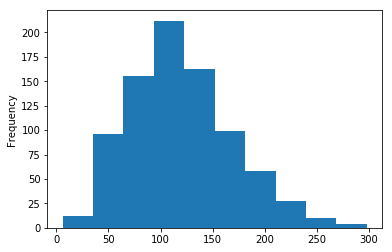

In [12]:
training_sampler = WeightedRandomSampler(training_dataset.weights, len(training_dataset))

dataloader = DataLoader(training_dataset, batch_size=50,
                        num_workers=4,# shuffle=True)
                        sampler=training_sampler)
all_labels_test = Counter()
texts_lengths = []
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch)
    features, labels, article = sample_batched
    words, stopwords, pos, references = features
    print(words.shape, stopwords.shape, references.shape, labels.shape)
    labels_list = labels.tolist()
    print(labels_list)
    all_labels_test.update(labels_list)
    if (i_batch>=2000):
        break

pd.Series(all_labels_test).plot(kind='hist')
print(all_labels_test.most_common(100))


In [13]:
training_dataset.article_data.vocabulary_size

50001

In [14]:
class Net(nn.Module):

    def __init__(self, seq_length=1500, filter_size=4, nr_filters=100, nr_classes=1, hidden_layers=[], 
                 vocab_size=20001, embedding_size=30, convolutions=True, pretrained_embeddings_size=300,
                 stopwords_dim=179, references_dim=31889, references_hidden_dim=30, pos_dim=32,
                dropout=0, nr_filters_pos=20, filter_size_pos=4,
                 ignore_features=[False, False, False, False, False], pretrained_embedding_weights=None):
        super(Net, self).__init__()
        self.seq_length = seq_length
        self.seq_length_contexts = 1000
        self.filter_size = filter_size
        self.nr_filters = nr_filters
        self.nr_classes = nr_classes
        self.filter_size_pos = filter_size_pos
        self.nr_filters_pos = nr_filters_pos
        self.pos_dim = pos_dim
        self.convolutions = convolutions
        self.embeddings_size = embedding_size
        self.dropout = dropout
        self.ignore_features = ignore_features
        if self.dropout:
            self.dropout_layer1 = nn.Dropout(p=self.dropout)
            self.dropout_layer2 = nn.Dropout(p=self.dropout)
        prev_dim = 0

        if not ignore_features[0]:
            self.pretrained_embeddings_size = pretrained_embeddings_size
            if self.pretrained_embeddings_size:
                self.embeddings_size = self.pretrained_embeddings_size
            else: 
                self.embedding = nn.Embedding(vocab_size, embedding_size)
                self.embedding.weights = pretrained_embedding_weights
            prev_dim = self.embeddings_size
            if convolutions:
                self.conv1 = nn.Conv1d(in_channels=self.embeddings_size, out_channels=self.nr_filters, 
                                       kernel_size=self.filter_size)
                self.conv_output_dim = self.seq_length - self.filter_size + 1

                self.pool = nn.MaxPool1d(kernel_size=self.conv_output_dim)
                prev_dim = self.nr_filters

        
        if not ignore_features[2]:
            self.pos_conv = nn.Conv1d(in_channels=self.pos_dim, out_channels=self.nr_filters_pos, 
                                      kernel_size=self.filter_size_pos)
            self.pos_conv_output_dim = self.seq_length - self.filter_size_pos + 1
            self.pos_pool = nn.MaxPool1d(kernel_size=self.pos_conv_output_dim)
            prev_dim += self.nr_filters_pos
            
        if not ignore_features[3]:
            if references_hidden_dim:
                self.references_hidden_layer = nn.Linear(references_dim, references_hidden_dim)
            else:
                self.references_hidden_layer = None
                references_hidden_dim = references_dim
            prev_dim +=  references_hidden_dim

        self.hidden = nn.ModuleList([])
        if not ignore_features[1]:
            prev_dim += stopwords_dim
        for hidden_layer in hidden_layers:
            if not hidden_layer:
                continue
            self.hidden.append(nn.Linear(prev_dim, hidden_layer))
            prev_dim = hidden_layer
        # output layer
        self.fc = nn.Linear(prev_dim, nr_classes, bias=True)
#         self.output = nn.Softmax(dim=1)
    

    def forward(self, features):
#         print("Original x", x.shape)
#         words, stopwords, references = features
        if not self.ignore_features[0]:
            if not self.pretrained_embeddings_size:
                features[0] = self.embedding(features[0])
                if self.dropout:
                    features[0] = self.dropout_layer1(features[0])
    #         print("Embedded x", x.shape)


            if self.convolutions:
                features[0] = features[0].transpose(1,2)
                features[0] = F.relu(self.conv1(features[0]))
                features[0] = self.pool(features[0])
                # flatten
                features[0] = features[0].view(-1, self.num_flat_features(features[0]))

            else:
                features[0] = features[0].sum(dim=1)
        if not self.ignore_features[2]:
#             features[2] = features[2].transpose(1,2) # TODO: do I need to do this?
#             features[2] = features[2].view(-1, 1, self.num_flat_features(features[2]))
            features[2] = F.relu(self.pos_conv(features[2]))
            features[2] = self.pos_pool(features[2])
            features[2] = features[2].view(-1, self.num_flat_features(features[2]))

        if not self.ignore_features[3]:
            if self.references_hidden_layer:
#                 print("References before embedding", features[3])
                features[3] = F.relu(self.references_hidden_layer(features[3]))
#                 print("References after embedding", features[3], "shape", features[3].shape)

        x = torch.cat([f for i, f in enumerate(features) if not self.ignore_features[i]], dim=1)
#         print("Concatenated x", x, "shape", x.shape)
        for i, hidden in enumerate(self.hidden):
            x = F.relu(hidden(x))
#             print("x after hidden layer", x, "shape", x.shape)

        if self.dropout:
            x = self.dropout_layer2(x)
        x = self.fc(x)
#         print("Final layer x", x.shape)
#         x = self.output(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net(convolutions=True, hidden_layers=[1000, 100], nr_classes=53)
print(net)



Net(
  (conv1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
  (pool): MaxPool1d(kernel_size=1497, stride=1497, padding=0, dilation=1, ceil_mode=False)
  (pos_conv): Conv1d(32, 20, kernel_size=(4,), stride=(1,))
  (pos_pool): MaxPool1d(kernel_size=1497, stride=1497, padding=0, dilation=1, ceil_mode=False)
  (references_hidden_layer): Linear(in_features=31889, out_features=30, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=329, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=100, bias=True)
  )
  (fc): Linear(in_features=100, out_features=53, bias=True)
)


In [15]:
def average_precision_recall(predicted_ranking, true_authors):
    '''Computes average precision and recall for a given article.'''
    precisions = []
    recalls = []
    reciprocal_rank = 0
    for rank, _ in enumerate(predicted_ranking):
#         print("Predicted ranking", predicted_ranking)
        predicted_authors = predicted_ranking[:rank+1]
#         print("predicted authors", predicted_authors)
        correct_predictions = set(predicted_authors).intersection(set(true_authors))
#         print("Correct predictions", correct_predictions)
        # precision = float(len(correct_predictions))/min((rank+1), len(true_authors))
        precision = float(len(correct_predictions))/(rank+1)
        recall = float(len(correct_predictions))/len(true_authors)
        recalls.append(recall)
        precisions.append(precision)

        # find first rank where at least one prediction is correct
        if len(correct_predictions) > 0:
            if reciprocal_rank == 0:
                reciprocal_rank = 1./(rank+1)
    return sum(precisions)/len(precisions), sum(recalls)/len(recalls), reciprocal_rank, precisions, recalls


In [16]:
def evaluate(net, data, topn=10, loss=None,  gpu=False, max_batches=20):
    loader = DataLoader(data, batch_size=50,
                        shuffle=True, num_workers=1)
    total_correct = 0
    total = 0
    losses = []
    precisions = []
    recalls = []
    RRs = []
    net.eval()
    for i, batch in enumerate(loader):
        features, labels, article = batch
        print(features[0], features[0].shape)
        if gpu:
            outputs = net([f.cuda() for f in features])
        else:
            outputs = net(features)
        if loss:
            if gpu:
                loss_size = loss(outputs, labels.cuda())
            else:
                loss_size = loss(outputs, labels)
            losses.append(loss_size.item())
        predictions = torch.sort(outputs, descending=True, dim=1)[1][:,:topn].cpu()
        if not loss: # it means these are multi labels
            labels_list = [l.nonzero().flatten() for l in labels]
            # TODO: this needs to be done for each example not each batch. It is...
            for i, prediction in enumerate(predictions):
                precision, recall, RR, _, _ = average_precision_recall(predictions[i].tolist(), labels_list[i].tolist())
                precisions.append(precision)
                recalls.append(recall)
                RRs.append(RR)
        else:
            labels_list = labels.tolist()
        correct = [len(np.intersect1d(predictions[j], labels_list[j]))>0 for j in range(len(predictions))]
        print("len predictions", len(predictions), "len correct", len(correct), "correct", correct)
        total_correct += sum(correct)
        total += len(correct)
        if i > max_batches:
            break
    MAP = float(sum(precisions))/len(precisions) if precisions else None
    MAR = float(sum(recalls))/len(recalls) if recalls else None
    MRR = float(sum(RRs))/len(RRs) if RRs else None
    accuracy = float(total_correct)/total
    return {'accuracy': accuracy, 'loss': losses, 'MAP': MAP, 'MAR': MAR, 'MRR': MRR}

In [17]:
# cuda.init()

torch.cuda.empty_cache()

In [18]:
hyperparams = {"epochs": 150,
#               "learning_rate": 0.001,
              "learning_rate": 0.0001,
              "batch_size": 128,
              'hidden_layers': 0,
              'weight_decay': 0.0001,
              'convolutions': True,
               'filters': 300,
               'filter_width': 9,
               'nr_filters_pos': 50,
               'references_hidden_dim': 1000,
              'lr_decrease_step': 5,
              'lr_decrease_rate': 10,
               'dropout': 0.5,
              'optimizer': 'adam',
               'momentum': 0.9,
               'just_abstract': False,
               'just_context': False,
              'ignore_features': [False, False, False, False]}

In [ ]:
# %%time



losses = []
accuracies = []
training_accuracies = []
validation_losses = []
max_batches = 1000000
all_predictions = Counter()
all_labels = Counter()
eval_freq = 200

def train(hyperparams, training_data, validation_data, validation_data_single, training_validation_data=None, 
          gpu=False, log_experiment=True, experiment_tags=[]):
    net = Net(filter_size=hyperparams['filter_width'], nr_filters=hyperparams['filters'], hidden_layers=[hyperparams['hidden_layers']], 
              nr_classes=training_dataset.nr_labels, nr_filters_pos=hyperparams['nr_filters_pos'],
              vocab_size=training_dataset.article_data.vocabulary_size, convolutions=hyperparams['convolutions'],
              seq_length=sequence_length, stopwords_dim=training_data.article_data.stopwords_dim,
              references_dim=training_data.article_data.references_dim,
              references_hidden_dim=hyperparams['references_hidden_dim'], pos_dim=max(training_dataset.POS_index.values())+1,
             embedding_size=300, pretrained_embeddings_size=0, dropout=hyperparams['dropout'],
             ignore_features=hyperparams['ignore_features'])
    experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                        project_name="general", workspace="ananana", disabled=not log_experiment)
    print(net)
            
    experiment.add_tags(experiment_tags + ["correct", "correct_pos"])
    experiment.log_parameters(hyperparams)
    experiment.log_parameters({"seq_length": sequence_length, 
                               "vocab_size": training_dataset.article_data.vocabulary_size,
                              "nr_classes": training_data.nr_labels})
    if gpu:
        net = net.cuda()
    loss = torch.nn.CrossEntropyLoss()
    #Optimizer
    optimizer_names = {
        'adam': torch.optim.Adam,
        'adagrad': torch.optim.Adagrad,
        'sgd': torch.optim.SGD,
        'adadelta': torch.optim.Adadelta
    }
    optimizer_class = optimizer_names[hyperparams['optimizer']]
    optimizer = optimizer_class(net.parameters(), lr=hyperparams['learning_rate'], 
                                weight_decay=hyperparams['weight_decay'])
    max_acc = 0

#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1./hyperparams['lr_decrease_rate'], 
#                                                            patience=hyperparams['lr_decrease_step'],
#                                                            verbose=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)
    for e in range(hyperparams['epochs']):
        train_loader = DataLoader(training_data, batch_size=hyperparams['batch_size'],
                        sampler=training_sampler, num_workers=4)
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            features, labels, article = batch
#             features = [features[0], features[1], features[3]] # skip pos for now

#             for param in net.parameters():
#                 print(param.name, param.size())
#             print("features", features, [f.dtype for f in features])
            if gpu:
                outputs = net([f.cuda() for f in features])
                loss_size = loss(outputs, labels.cuda())
            else:
                outputs = net(features)
                loss_size = loss(outputs, labels)
            print("Loss:", loss_size.data.item())
            losses.append(loss_size.data.item())
            loss_size.backward()
            optimizer.step()
            
            predictions = outputs.cpu().sort(descending=True)[1][:,:10]
            labels_list = labels.tolist()

            correct = [len(np.intersect1d(predictions[j], labels_list[j])) for j in range(len(predictions))]
            training_accuracy = sum(correct)/float(hyperparams['batch_size'])
            training_accuracies.append(training_accuracy)
            print("training_accuracy", training_accuracy)

            all_predictions.update(sum([p.tolist()[:10] for p in predictions], []))
            all_labels.update(labels_list)

            experiment.log_metric("train_acc", float(training_accuracy))
            experiment.log_metric("loss", float(loss_size.item()))
            
            if i%eval_freq==0:
                metrics = evaluate(net, validation_data, topn=10, gpu=gpu)
                metrics2 = evaluate(net, validation_data_single, loss=loss, topn=10, gpu=gpu)

                print("predictions", predictions)
                print("predictions shape", predictions.shape)
                print("features shape", [f.shape for f in features])
                print("features", features)
                print("correct", correct)
                print("labels", labels)
                print("batch size", hyperparams['batch_size'])
                validation_losses.extend(metrics2['loss'])
                print(metrics)
                print(metrics2)
                experiment.log_metric("acc", float(metrics['accuracy']))
                avg_eval_loss = float(sum(metrics2['loss']))/len(metrics2['loss'])
                experiment.log_metric("eval_loss", avg_eval_loss)
                experiment.log_metric("MAP", float(metrics['MAP']))
                experiment.log_metric("MAR", float(metrics['MAR']))
                experiment.log_metric("MRR", float(metrics['MRR']))
                
                if float(metrics['accuracy']) > max_acc:
                    max_acc = float(metrics['accuracy'])
                    with open("best_modelx.pkl", "wb+") as f:
                        pickle.dump(net, f)
                
#                 scheduler.step(avg_eval_loss)
                scheduler.step()
                net.train()
            accuracies.append(metrics['accuracy'])

            
            if i > max_batches:
                break
            print("batch", i, "epoch", e, "learning rate", optimizer.param_groups[0]['lr'])
       
            # Note: updating backprop once an epoch :O. no, just the scheduler! ? 
        

#         if e%hyperparams['lr_decrease_step']==0:
#             for g in optimizer.param_groups:
#                 g['lr'] = g['lr']/hyperparams['lr_decrease_rate']
    if log_experiment:
        return experiment, net
    else:
        return net

net=train(hyperparams, training_dataset, validation_dataset, validation_dataset_single, gpu=True, 
      log_experiment=True, experiment_tags=["exp", "correct_conv", "scheduler_plateau", "ablation"])

COMET INFO: old comet version (1.0.49) detected. current: 1.0.50 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ananana/general/e0498f5e10a34ee6bab44889fb763a11



Net(
  (dropout_layer1): Dropout(p=0.5)
  (dropout_layer2): Dropout(p=0.5)
  (embedding): Embedding(50001, 300)
  (conv1): Conv1d(300, 300, kernel_size=(9,), stride=(1,))
  (pool): MaxPool1d(kernel_size=92, stride=92, padding=0, dilation=1, ceil_mode=False)
  (pos_conv): Conv1d(36, 50, kernel_size=(4,), stride=(1,))
  (pos_pool): MaxPool1d(kernel_size=97, stride=97, padding=0, dilation=1, ceil_mode=False)
  (references_hidden_layer): Linear(in_features=10987, out_features=1000, bias=True)
  (hidden): ModuleList()
  (fc): Linear(in_features=1529, out_features=200, bias=True)
)
Loss: 5.512053489685059
training_accuracy 0.078125
tensor([[50000,  2706,  1579,  ..., 50000, 50000,   101],
        [  652, 50000,  4090,  ...,    65, 50000, 50000],
        [  393, 50000,   662,  ...,   265, 50000,  2290],
        ...,
        [50000, 50000,  1645,  ..., 50000,  1864, 50000],
        [   42,   494, 50000,  ...,   168,  2563, 50000],
        [50000, 50000, 18678,  ...,    28, 50000, 50000]]) torc

In [19]:
def evaluate_per_article(net, data, topn=10, loss=None,  gpu=False, max_batches=1000, cutoff=10):
    loader = DataLoader(data, batch_size=50,
                        shuffle=False, num_workers=0)
    outputs_for_article = {}
    labels_for_article = {}
    total_correct = 0
    total = 0
    losses = []
    precisions = []
    recalls = []
    RRs = []
    total_correct = 0
    total = 0
    for i, batch in enumerate(loader):
        features, labels, articles = batch

        if gpu:
            outputs = net([f.cuda() for f in features])
        else:
            outputs = net(features)
        if loss:
            if gpu:
                loss_size = loss(outputs, labels.cuda())
            else:
                loss_size = loss(outputs, labels)
        for i, article in enumerate(articles):
            output = outputs[i]
            if article not in outputs_for_article:
                outputs_for_article[article] = output
            else:
                outputs_for_article[article] = torch.cat((outputs_for_article[article], output))
            labels_for_article[article] = [l[0] for l in labels[i].nonzero().tolist()]
            
    # TODO: this needs to be done for each example not each batch
  
    for article in outputs_for_article:
        outputs = outputs_for_article[article]
        labels = labels_for_article[article]
        probabilities, predictions = outputs.cpu().sort(descending=True)
        # readjust indices to correspond to classes. the vector got longer than the number
        # of classes when you concatenated everything
        predictions = [p.item()%data.article_data.nr_labels for p in predictions]
        top_predictions = []
        for p in predictions:
            if p not in top_predictions:
                top_predictions.append(p)
            if len(top_predictions) >= topn:
                break

        
        print(top_predictions, labels)
        precision, recall, RR, _, _ = average_precision_recall(top_predictions, labels)
        precisions.append(precision)
        recalls.append(recall)
        RRs.append(RR)

        correct = np.intersect1d(top_predictions, labels)
        if len(correct)>0:
            total_correct += 1
        total += 1
#     total_correct = sum(correct)
#     total = len(correct)
    print("%d correct out of %d" % (total_correct, total))
    MAP = float(sum(precisions))/len(precisions) if precisions else None
    MAR = float(sum(recalls))/len(recalls) if recalls else None
    MRR = float(sum(RRs))/len(RRs) if RRs else None
    accuracy = float(total_correct)/total
    return {'accuracy': accuracy, 'loss': losses, 'MAP': MAP, 'MAR': MAR, 'MRR': MRR}

In [50]:
[(a, c) for (a, c) in test_dataset.article_data.classes.items() if c in [15, 2, 4, 514, 443, 66, 0, 38, 240, 190, 193]]

[('Eugene Charniak', 15),
 ('Mark Johnson', 2),
 ('Kenji Sagae', 190),
 ('Lenhart K Schubert', 443),
 ('Brian Roark', 38),
 ('Slav Petrov', 240),
 ('Reut Tsarfaty', 514),
 ('Jonas Kuhn', 66),
 ('Daniel Jurafsky', 193),
 ('Dan Klein', 0),
 ('Christopher D Manning', 4)]

In [45]:
test_dataset.article_data.authors

{'P00-1020': {'authors': ['Giuseppe Carenini', 'Johanna D Moore'],
  'title': 'An Empirical Study of the Influence of Argument Conciseness on Argument Effectiveness'},
 'P00-1031': {'authors': ['Zheng Chen', 'Kai-Fu Lee'],
  'title': 'A New Statistical Approach to Chinese Pinyin Input'},
 'P00-1038': {'authors': ['Adam Berger', 'Vibhu O Mittal'],
  'title': 'Query-Relevant Summarization using FAQs'},
 'P00-1067': {'authors': ['Ting Liu',
   'Ming Zhou',
   'Jianfeng Gao',
   'Endong Xun',
   'Changning Huang'],
  'title': 'PENS: A Machine-aided English Writing System for Chinese Users'},
 'P00-1077': {'authors': ['Akshar Bharati',
   'Vineet Chaitanya',
   'Rajeev Sangal'],
  'title': 'COMPUTATIONAL LINGUISTICS IN INDIA: AN OVERVIEW'},
 'P01-1019': {'authors': ['Ann Copestake',
   'Alex Lascarides',
   'Dan Flickinger'],
  'title': 'An Algebra for Semantic Construction in Constraint-based Grammars'},
 'P01-1022': {'authors': ['John Dowding',
   'Beth Ann Hockey',
   'Jean Mark Gawron',

In [39]:
test_dataset.article_data.authors

{'P00-1020': {'authors': ['Giuseppe Carenini', 'Johanna D Moore'],
  'title': 'An Empirical Study of the Influence of Argument Conciseness on Argument Effectiveness'},
 'P00-1031': {'authors': ['Zheng Chen', 'Kai-Fu Lee'],
  'title': 'A New Statistical Approach to Chinese Pinyin Input'},
 'P00-1038': {'authors': ['Adam Berger', 'Vibhu O Mittal'],
  'title': 'Query-Relevant Summarization using FAQs'},
 'P00-1067': {'authors': ['Ting Liu',
   'Ming Zhou',
   'Jianfeng Gao',
   'Endong Xun',
   'Changning Huang'],
  'title': 'PENS: A Machine-aided English Writing System for Chinese Users'},
 'P00-1077': {'authors': ['Akshar Bharati',
   'Vineet Chaitanya',
   'Rajeev Sangal'],
  'title': 'COMPUTATIONAL LINGUISTICS IN INDIA: AN OVERVIEW'},
 'P01-1019': {'authors': ['Ann Copestake',
   'Alex Lascarides',
   'Dan Flickinger'],
  'title': 'An Algebra for Semantic Construction in Constraint-based Grammars'},
 'P01-1022': {'authors': ['John Dowding',
   'Beth Ann Hockey',
   'Jean Mark Gawron',

In [24]:
# pickle.dump(trained_net, open("model5_100.pkl", "wb+"))
trained_net = pickle.load(open("datasets_serialized/model_best_922.pkl", "rb"))

In [ ]:
trained_net2 = trained_net

In [27]:
# Test on the test set
# experiment, trained_net = net
# import torch.multiprocessing
# torch.multiprocessing.set_sharing_strategy('file_system')
print(evaluate_per_article(trained_net.cuda(), test_dataset, gpu=True, max_batches=10000000))
print(evaluate(trained_net.cuda(), test_dataset, gpu=True, max_batches=100000))

RuntimeError: CUDA out of memory. Tried to allocate 4.62 MiB (GPU 0; 3.94 GiB total capacity; 3.09 GiB already allocated; 4.44 MiB free; 141.79 MiB cached)

In [61]:
[(c, i) for c, i in test_datapoint.article_data.classes.items() if i in [92, 94, 488, 216, 53, 94, 92,
                                                                         378, 137, 139,
                                                                        92, 541, 94, 92, 92, 28, 363, 488, 98, 94]]

NameError: name 'test_datapoint' is not defined

In [97]:
[(c, i) for c, i in test_datapoint.article_data.classes.items() if i in [5, 92, 23, 5, 92, 5, 92, 92, 93, 5, 47, 
                                                                         51, 2, 78]]
# [(c, i) for c, i in test_datapoint.article_data.classes.items() if i in [63, 56, 4]]


[('Grzegorz Kondrak', 92),
 ('Mark Johnson', 2),
 ('Kevin Knight', 5),
 ('Owen Rambow', 51),
 ('Daniel Gildea', 23),
 ('Robert C Moore', 93),
 ('Dan Jurafsky', 47),
 ('Aravind K Joshi', 78)]

In [95]:
test_datapoint.data[0]

(['ew',
  'system',
  'for',
  'sci',
  'entific',
  'publications',
  'notably',
  'show',
  'the',
  'authors',
  'of',
  'scientific',
  'article',
  'can',
  'be',
  'blind',
  'review',
  'published',
  'in',
  'journal',
  'of',
  'psychology',
  'shows',
  'that',
  'authors',
  'of',
  'anonymous',
  'papers',
  'could',
  'be',
  'atic',
  'approach',
  'for',
  'author',
  'prediction',
  'for',
  'example',
  'successfully',
  'predicted',
  'the',
  'au',
  'thors',
  'of',
  'scientifi',
  'mpetition',
  'using',
  'only',
  'the',
  'arti',
  'cles',
  'references',
  'performed',
  'experiments',
  'for',
  'predicting',
  'authors',
  'of',
  'ientific',
  'article',
  'texts',
  'but',
  'for',
  'different',
  'task',
  'propose',
  'using',
  'modularized',
  'hi',
  'erarchical',
  'cnns',
  'for',
  'for',
  'automatic',
  'rating',
  'of',
  'academic',
  'articles',
  'in',
  'the',
  'authors',
  'propose',
  'using',
  'an',
  'author',
  'topic',
  'model',
  

In [ ]:
torch.tensor([0,0,1,0,0]).nonzero().item()

In [ ]:

from matplotlib import pyplot as plt
plt.plot(losses)
# plt.ylim(0, 100)
rolling = pd.DataFrame(losses).rolling(50).mean()
rolling_validation = pd.DataFrame(validation_losses).rolling(10).mean()
plt.plot(rolling)
step = int(len(losses)/len(validation_losses))
step2 = int(len(losses)/len(rolling_validation))
plt.plot(range(0, step*len(validation_losses), step), validation_losses)
plt.plot(range(0, step2*len(rolling_validation), step2), rolling_validation)
plt.show()


In [ ]:
plt.plot(accuracies)
rolling = pd.DataFrame(accuracies).rolling(50).mean()
rolling_training = pd.DataFrame(training_accuracies).rolling(50).mean()
# plt.plot(rolling)
plt.plot(rolling_training)
plt.show()

In [ ]:
from comet_ml import Optimizer
optimizer = Optimizer("eoBdVyznAhfg3bK9pZ58ZSXfv")
# Declare your hyper-parameters:
params = """
learning_rate real [0.00001, 0.01] [0.0001]
batch_size integer [100, 512] [256]
hidden_layers categorical {100, 200, 300, 400, 500, 600, 700, 800, 900, 1000} [500]
weight_decay real [0.001, 0.1] [0.01]
lr_decrease_step integer [1, 20] [5]
lr_decrease_rate integer [2, 10] [10]
filters categorical {50, 70, 100, 150, 175, 200} [200]
references_hidden_dim categorical {10, 50, 100, 200, 300, 500, 700, 1000, 1200, 1500, 1700, 2000} [500]
dropout real [0.0, 0.5] [0.4]
optimizer categorical {adam, adagrad, sgd} [adam]
"""
"""
ignore_features categorical {[False, False, False, False], [False, True, True, True], [True, False, True, True], [True, True, False, True], [True, True, True, False]} [[False, False, False, False]]
"""
optimizer.set_params(params)

all_losses = []
all_accuracies = []
all_training_accuracies = []
all_validation_losses = []
all_hyperparams = []

while True:
    losses = []
    accuracies = []
    training_accuracies = []
    validation_losses = []
    # Get a suggestion
    suggestion = optimizer.get_suggestion()

    # Create a new experiment associated with the Optimizer
#     experiment = Experiment("eoBdVyznAhfg3bK9pZ58ZSXfv")

    # Test the model
    hyperparams["learning_rate"] = suggestion["learning_rate"]
    hyperparams["batch_size"] = suggestion["batch_size"]
    hyperparams["hidden_layers"] = suggestion["hidden_layers"]
    hyperparams["weight_decay"] = suggestion["weight_decay"]
    hyperparams["lr_decrease_step"] = suggestion["lr_decrease_step"]
    hyperparams["lr_decrease_rate"] = suggestion["lr_decrease_rate"]  
    hyperparams["optimizer"] = suggestion["optimizer"]
    hyperparams["references_hidden_dim"] = suggestion["references_hidden_dim"]
    hyperparams["dropout"] = suggestion["dropout"]
    experiment, net = train(hyperparams, training_dataset, validation_dataset, validation_dataset_single, 
                       gpu=True, experiment_tags=["tune", "correct_conv", "ablation"])
    score = sum(accuracies[-100:])/len(accuracies[-100:])
#     score = eval_loss
    # Report the score back
    suggestion.report_score("avg_accuracy",score)
    
    all_losses.append(losses)
    all_accuracies.append(accuracies)
    all_validation_losses.append(validation_losses)
    all_training_accuracies.append(training_accuracies)
    all_hyperparams.append(hyperparams)
    with open("experiments/experiment" + experiment.id, "wb+") as log: 
        pickle.dump({'losses': losses, 'accuracies': accuracies, 
                     'training_accuracies': training_accuracies, 'hyperparams': hyperparams}, log)

In [ ]:
# Hyperparameter search
hyperparameter_space = {
    "learning_rate": [0.001, 0.01, 0.0001],
    "epochs": [20],
    "batch_size": [50, 100, 256, 512],
    'hidden_layers': [150, 200, 100, 400, 50],
    'weight_decay': [0.01, 0.2, 0.5, 0.9, 1.5],
}

for key in hyperparameter_space:
    for value in hyperparameter_space[key]:
        
        

In [ ]:
print(sum([f for l,f in all_labels.most_common()]))
print(sum([f for l,f in all_labels.most_common(10)]))
print(sum([f for l,f in all_labels.most_common(1)]))

print(sum([f for l,f in all_predictions.most_common()]))
print(sum([f for l,f in all_predictions.most_common(10)]))
print(sum([f for l,f in all_predictions.most_common(1)]))

print(all_labels.most_common(), all_predictions.most_common())


# pd.Series(all_predictions).hist()
# pd.Series(all_labels).hist()
predictions_nl = []
for i in all_predictions:
    if i not in all_labels:
        predictions_nl.append(i)
print("not in labels", predictions_nl)
pd.Series(predictions_nl).hist()

In [ ]:
for p in net.parameters():
    print(p, p.shape)

In [ ]:
%%time
texts = collect_texts().values()
lengths = [len(t.split()) for t in texts]
pd.Series([l for l in lengths if l <10000]).hist(bins=200)
plt.show()

### Author statistics

In [21]:
def get_authors_list(dataset):
    # TODO: issue: this doesn't remove occurrences of authors from articles
    # where all the co-authors were removed so the article is no longer in
    # the dataset?
    # Actually not a problem cause we keep articles authored by any number of
    # authors as long as there is at least one.
    return Counter(sum([[a for a in p['authors'] if a in dataset.article_data.classes]
                        for p in dataset.article_data.authors.values()], 
                  []))

def get_references(dataset):
    # TODO: issue: this doesn't remove occurrences of authors from articles
    # where all the co-authors were removed so the article is no longer in
    # the dataset?
    # Actually not a problem cause we keep articles authored by any number of
    # authors as long as there is at least one.
    references_inexp = {p: v for (p, v) in dataset.article_data.references.items()
                        if p in dataset.article_data.article_indices}
    return Counter(ArticleTextData._normalize_authors([a for a in sum(sum([(list(p.values())) 
                            for p in references_inexp.values()], []), 
                       []) if a in dataset.article_data.classes]))


training_authors_freq = get_authors_list(training_dataset)
test_authors_freq = get_authors_list(test_dataset)
validation_authors_freq = get_authors_list(validation_dataset)

training_authors_freq.update(test_authors_freq)
training_authors_freq.update(validation_authors_freq)
training_authors_freq.most_common()

training_references = get_references(training_dataset)
test_references = get_references(test_dataset)
validation_references = get_references(validation_dataset)

training_references.update(test_references)
training_references.update(validation_references)
training_references.most_common()
# pickle.dump(training_authors_freq, open("datasets_serialized/authors_freq_emnlp_262.pkl", "wb+"))

[('D Klein', 251),
 ('K Knight', 186),
 ('P Koehn', 171),
 ('M Collins', 148),
 ('C Manning', 140),
 ('A Mccallum', 112),
 ('L Huang', 109),
 ('R Mcdonald', 98),
 ('Q Liu', 93),
 ('C Callison-Burch', 84),
 ('H Ney', 83),
 ('A Moschitti', 79),
 ('M Lapata', 75),
 ('S Petrov', 74),
 ('J Eisner', 74),
 ('P Resnik', 74),
 ('R Barzilay', 73),
 ('I Iii', 66),
 ('J Nivre', 64),
 ('C Dyer', 62),
 ('M Galley', 59),
 ('C Cardie', 58),
 ('Y Liu', 58),
 ('S Clark', 57),
 ('O Etzioni', 56),
 ('M Zhang', 55),
 ('D Roth', 54),
 ('H Daumé', 54),
 ('A Haghighi', 54),
 ('P Liang', 51),
 ('A Ng', 50),
 ('D Jurafsky', 44),
 ('Y Matsumoto', 42),
 ('S Riedel', 42),
 ('N Smith', 42),
 ('E Hovy', 42),
 ('B Liu', 41),
 ('H Mi', 40),
 ('E Riloff', 39),
 ('S Kurohashi', 39),
 ('C Quirk', 39),
 ('T Cohn', 37),
 ('S Goldwater', 37),
 ('V Ng', 37),
 ('M Steedman', 37),
 ('X Carreras', 37),
 ('P Blunsom', 35),
 ('H Ng', 32),
 ('M Zhou', 32),
 ('R Mihalcea', 32),
 ('H Li', 31),
 ('J Denero', 31),
 ('Y Choi', 31),
 ('

In [20]:
len(training_dataset.article_data.classes)

100

In [22]:
all_authors_list = list(training_authors_freq.keys())
print(len(all_authors_list))

# Removing middle names
all_authors_seminormalized = [" ".join([a.split(" ")[0], a.split(" ")[-1]]) 
                              for a in all_authors_list]
# all_authors_seminormalized = list(set(all_authors_seminormalized))

# all_authors_seminormalized
all_authors_normalized = ArticleTextData._normalize_authors(all_authors_seminormalized)
print(len(all_authors_normalized))
# Counter(all_authors_seminormalized).most_common()
# plt.bar(range(len(set(all_authors_normalized))), 
#         sorted(list(Counter(all_authors_normalized).values()), reverse=True),
#         log=False)
collisions_counter = Counter(all_authors_normalized)
collisions_counter.most_common()
# [a for a,f in collisions_counter.items() if f > 1]
collisions_emnlp = [a for a in all_authors_list
              if collisions_counter[ArticleTextData._normalize_authors([a])[0]] > 1]
collisions_emnlp = sorted(collisions_emnlp, key=lambda n: n.split()[-1])
# open("collisions_emnlp", "w+").write("\n".join(collisions_emnlp))

100
100


In [23]:
collisions_emnlp

['Yue Zhang', 'Yi Zhang']

In [25]:
# collided_authors = [a for a, f in Counter(all_authors_normalized).most_common() if f > 1]
with open("collisions_emnlp", "r") as f:
    collisions_emnlp_full = f.read().split("\n")
[a for a in collisions_emnlp_full if a in training_dataset.article_data.classes]

['Zhongqiang Huang', 'Daniel Jurafsky', 'Yue Zhang', 'Yi Zhang']

In [81]:
authors_freq_acl = training_authors_freq

In [85]:
authors_freq_emnlp = training_authors_freq

Text(0.5, 0, 'EMNLP authors')

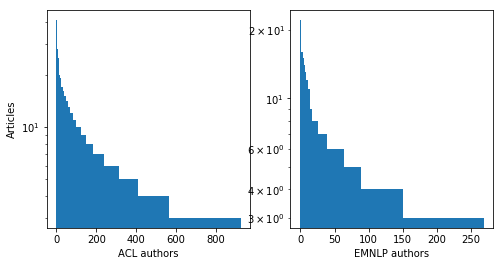

In [117]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
ax[0].bar(range(len(authors_freq_acl)), 
        sorted(authors_freq_acl.values(), reverse=True), 
        width=2.75, log=False)
ax[0].set_xlabel('ACL authors')
ax[0].set_ylabel('Articles')

ax[1].bar(range(len(authors_freq_emnlp)), 
        sorted(authors_freq_emnlp.values(), reverse=True), 
        width=2.75, log=False)
ax[1].set_xlabel('EMNLP authors')


In [124]:
with open("acl_author_freqs.csv", "w+") as fa:
    for a, f in authors_freq_acl.most_common():
        fa.write(a + "," + str(f) + "\n")

with open("emnlp_author_freqs.csv", "w+") as fa:
    for a, f in authors_freq_emnlp.most_common():
        fa.write(a + "," + str(f) + "\n")

In [138]:
# [p.values() for p in training_dataset.article_data.references.values()]
references_inexp = {p: v for (p, v) in training_dataset.article_data.references.items() if p in
    training_dataset.article_data.article_indices}
sum(sum([list(p.values()) for p in references_inexp.values()], []), [])

['Igor A Bolshakov',
 'Christiane Fellbaum',
 'Mikhail J Atallah',
 'Victor Raskin',
 'Michael C Crogan',
 'Christian Hempelmann',
 'Brian Murphy',
 'Mark Chapman',
 'George I Davida',
 'M',
 'Olga Vybornova',
 'Benoit Macq',
 'M Cuneyt',
 'Mercan Taskiran',
 'Edward J Topkara',
 'Delp',
 'Diana Mccarthy',
 'Roberto Navigli',
 'Mikhail J Atallah',
 'Craig J Mcdonough',
 'Victor Raskin',
 'Sergei Nirenburg',
 'Mikhail J Atallah',
 'Victor Raskin',
 'Christian F Hempelmann',
 'Mercan Karahan',
 'Umut Topkara',
 'Katrina E Triezenberg',
 'Radu Sion',
 'Umut Topkara',
 'Mercan Topkara',
 'Mikhail J',
 'K Jonathan',
 'James R Kummerfeld',
 'Curran',
 'Andrew Carlson',
 'Tom M Mitchell',
 'Ian Fette',
 'Ching-',
 'Yun Chang',
 'Stephen Clark',
 'Aminul Islam',
 'Diana Inkpen',
 'Thorsten Brants',
 'Alex Franz',
 'Brian Murphy',
 'Carl Vogel',
 'Mercan Topkara',
 'Umut Topkara',
 'Mikhail J Atallah',
 'Richard Bergmair',
 'M Hasan',
 'Emre Meral',
 'Ersin Sevinc',
 'Bulent Unkar',
 'A Sankur'

Testing data loaders

In [ ]:
class DummyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.weights = [1,1,2,2]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]

ds = DummyDataset(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p'])

In [ ]:
sampler = WeightedRandomSampler(ds.weights, 200)
dl = DataLoader(ds, sampler=sampler, batch_size=10)
allg = Counter()
for el in dl:
    print(el)
    allg.update(el)

pd.Series(allg).hist()
allg

In [116]:
for d in training_dataset:
    print(d)
    break

((tensor([ 4117, 23260,  2817,  2842, 23260,   268,   544, 23260,   635, 23260,
        23260,  2177,   214,   408,   176, 23260,   199, 23260,    32, 23260,
          254,   544, 17004, 23260, 23260,  1702,  1089, 23260,  3746, 23260,
         4108,  4932, 23260,    29,   708, 23260,  2227,  1463,   544,   992,
          385,   115,  5634, 23260, 23260,  3615, 23260, 23260,    80, 23260,
           12,   542,  1390,  1103,    28, 23260,   557,    12, 23260, 23260,
         1702,   115, 23260,     9,   764,    22, 23260,  2982, 23260,   698,
        23260,  6270, 23260,    65,  2842, 23260, 23260, 23260,    32,   107,
        23260,  3448, 23260,  2082, 23260, 23260,   698, 23260,    11,  1187,
           58, 23260, 23260,   586,    32,     7,  2763,   385,   533,   544]), tensor([0., 0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 